# Accelerating Cleantech Advancements through NLP-Powered Text Mining and Knowledge Extraction

Group: Marusa Storman, Vignesh Govindaraj, Pradip Ravichandran

## Stage 1: Enhanced Data Cleaning, Preprocessing, and Exploratory Analysis

### Data Collection

In [1]:
import sys
import os

# Get the directory of the current notebook
notebook_dir = os.getcwd()

# Change current working directory to where the notebook resides
os.chdir(notebook_dir)

# List of required libraries
required_libraries = [
    'json',
    'langdetect',
    'matplotlib',
    'nltk',
    'numpy',
    'pandas',
    'pyspellchecker',
    'scikit-learn',
    'seaborn',
    'string',
    'unidecode',
    'unicodedata',
    'wordcloud'
]

# Check if each library is installed, if not, install it
for lib in required_libraries:
    try:
        __import__(lib)
    except ImportError:
        print(f"Installing {lib}...")
        !"{sys.executable}" -m pip install {lib}

Installing pyspellchecker...
Installing scikit-learn...


In [2]:
import ast
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
# import spacy
import string
import unidecode
import unicodedata

from collections import Counter
from langdetect import detect
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from spellchecker import SpellChecker
from urllib.parse import urlparse, urlunparse
from wordcloud import WordCloud


# Jupyter config
%config InteractiveShell.ast_node_interactivity = 'all'

# Additional setup for seaborn
sns.set(color_codes=True)
sns.set_style("whitegrid")

# Download needed NLTK's resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pradip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pradip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Read the JSON file from https://www.kaggle.com/datasets/prakharbhandari20/cleantech-google-patent-dataset
google_patent_original = pd.read_json("Data/bq-results-20240124-055833-1706076079048.json", lines=True)

# Read the first CSV file from https://www.kaggle.com/datasets/jannalipenkova/cleantech-media-dataset
media_original = pd.read_csv("Data/cleantech_media_dataset_v2_2024-02-23.csv")

# Read the second CSV file from https://www.kaggle.com/datasets/jannalipenkova/cleantech-media-dataset
media_evaluation_original = pd.read_csv("Data/cleantech_rag_evaluation_data_2024-02-23.csv")

In [4]:
# This function will provide with more useful information:
def analyze_column(df, has_list=False):
    info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Number of Entries': df.count(),
        'Missing/None Count': df.isna().sum()
    })
    
    if not has_list:
        info['Uniqueness'] = df.nunique()

    
    return info

print("Google Patent Dataset:")
google_patent_original.head()
analyze_column(google_patent_original, has_list=True)

Google Patent Dataset:


,publication_number,application_number,country_code,title_localized,abstract_localized,publication_date,inventor,cpc
0,US-2022239235-A1,US-202217717397-A,US,[{'text': 'Adaptable DC-AC Inverter Drive Syst...,[{'text': 'Disclosed is an adaptable DC-AC inv...,20220728,[],"[{'code': 'H02M7/5395', 'inventive': True, 'fi..."
1,US-2022239251-A1,US-202217580956-A,US,[{'text': 'System for providing the energy fro...,[{'text': 'In accordance with an example embod...,20220728,[],"[{'code': 'H02S40/38', 'inventive': True, 'fir..."
2,EP-4033090-A1,EP-21152924-A,EP,[{'text': 'Verfahren zum steuern einer windene...,[{'text': 'Verfahren zum Steuern einer Windene...,20220727,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...","[{'code': 'F03D7/0276', 'inventive': True, 'fi..."
3,EP-4033090-A1,EP-21152924-A,EP,[{'text': 'Verfahren zum steuern einer windene...,[{'text': 'Verfahren zum Steuern einer Windene...,20220727,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...","[{'code': 'F03D7/0276', 'inventive': True, 'fi..."
4,US-11396827-B2,US-202117606042-A,US,[{'text': 'Control method for optimizing solar...,[{'text': 'A control method for optimizing a s...,20220726,[],"[{'code': 'F24S50/00', 'inventive': True, 'fir..."


,Data Type,Number of Entries,Missing/None Count
publication_number,object,30000,0
application_number,object,30000,0
country_code,object,30000,0
title_localized,object,30000,0
abstract_localized,object,30000,0
publication_date,int64,30000,0
inventor,object,30000,0
cpc,object,30000,0


In [5]:
print("Media Dataset:")
media_original.head()
analyze_column(media_original)
print("\nNumber of duplicate rows:", media_original.duplicated().sum())

Media Dataset:


,Unnamed: 0,title,date,author,content,domain,url
0,1280,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,NaN,"[""Qatar Petroleum ( QP) is targeting aggressiv...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
1,1281,India Launches Its First 700 MW PHWR,2021-01-15,NaN,"[""• Nuclear Power Corp. of India Ltd. ( NPCIL)...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
2,1283,New Chapter for US-China Energy Trade,2021-01-20,NaN,"[""New US President Joe Biden took office this ...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
3,1284,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,NaN,"[""The slow pace of Japanese reactor restarts c...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
4,1285,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,NaN,"[""Two of New York City's largest pension funds...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...


,Data Type,Number of Entries,Missing/None Count,Uniqueness
Unnamed: 0,int64,9593,0,9593
title,object,9593,0,9569
date,object,9593,0,967
author,object,31,9562,7
content,object,9593,0,9588
domain,object,9593,0,19
url,object,9593,0,9593



Number of duplicate rows: 0


In [6]:
print("Media Evaluation Dataset:")
media_evaluation_original.head()
analyze_column(media_evaluation_original)
print("\nNumber of duplicate rows:", media_evaluation_original.duplicated().sum())

Media Evaluation Dataset:


,example_id,question_id,question,relevant_chunk,article_url
0,1,1,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,https://www.sgvoice.net/strategy/technology/23...
1,2,2,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,https://www.sgvoice.net/policy/25396/eu-seeks-...
2,3,2,What is the EU’s Green Deal Industrial Plan?,The European counterpart to the US Inflation R...,https://www.pv-magazine.com/2023/02/02/europea...
3,4,3,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,https://www.sgvoice.net/policy/25396/eu-seeks-...
4,5,4,When did the cooperation between GM and Honda ...,What caught our eye was a new hookup between G...,https://cleantechnica.com/2023/05/08/general-m...


,Data Type,Number of Entries,Missing/None Count,Uniqueness
example_id,int64,23,0,23
question_id,int64,23,0,21
question,object,23,0,21
relevant_chunk,object,23,0,23
article_url,object,23,0,21



Number of duplicate rows: 0


### Data Cleaning
To preserve the original dataframe, it has been copied for the cleaning stage.

In [7]:
results_json = google_patent_original.copy()
ct_media = media_original.copy()
ct_evaluation = media_evaluation_original.copy()

#### Google patent

In [8]:
# Change to date format
results_json['publication_date'] = pd.to_datetime(results_json['publication_date'], format='%Y%m%d')
print("Earliest date:", results_json['publication_date'].min())
print("Latest date:", results_json['publication_date'].max())

Earliest date: 2021-11-23 00:00:00
Latest date: 2022-07-28 00:00:00


In [9]:
#### Flatts the nested JSON objects
def flat_dict_data(df, column_name):
    flattened_rows = []
    
    for _, row in df.iterrows():
        # Get the list of values
        specific_column = row.get(column_name, [])

        # If the column is empty, append the original row
        if not specific_column or len(specific_column) == 0:
            flattened_rows.append(row)
        else:
            # Iterate through each value
            for specific_column_value in specific_column:
                # Check if the value is a dictionary
                if isinstance(specific_column_value, dict):
                    # Flatten the JSON object
                    flattened_row = {f"{column_name}_{key}": value for key, value in specific_column_value.items() if value}
    
                    # Append the modified row
                    flattened_rows.append({**row, **flattened_row})
                    
    # Create a new DataFrame
    flatten_df = pd.DataFrame(flattened_rows)
    flatten_df.drop(columns=[column_name], inplace=True)
    return flatten_df

#### Flatts an array
def flat_list_data(df, column_name):
    flattened_rows = []
    
    for _, row in df.iterrows():
        # Get the list of values
        specific_column = row.get(column_name, [])  

        # If the column is empty, append the original row
        if len(specific_column) == 0:
            row[column_name] = np.nan
            flattened_rows.append(row)
        else:
            # Iterate through each value
            for value in specific_column:
                new_row = row.copy()
                new_row[column_name] = value
                flattened_rows.append(new_row)
    
    # Create a new DataFrame from flattened_rows
    flatten_df = pd.DataFrame(flattened_rows)
    return flatten_df

google_patent_normalized = flat_dict_data(results_json, 'title_localized')
google_patent_normalized = flat_dict_data(google_patent_normalized, 'abstract_localized')
google_patent_normalized = flat_dict_data(google_patent_normalized, 'cpc')
google_patent_normalized = flat_list_data(google_patent_normalized, 'inventor')

google_patent_normalized.head()
analyze_column(google_patent_normalized)
results_json = google_patent_normalized.copy()

,publication_number,application_number,country_code,publication_date,inventor,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language,cpc_code,cpc_inventive,cpc_first
0,US-2022239235-A1,US-202217717397-A,US,2022-07-28,NaN,Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en,H02M7/5395,True,NaN
1,US-2022239235-A1,US-202217717397-A,US,2022-07-28,NaN,Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en,H02J3/32,NaN,NaN
2,US-2022239235-A1,US-202217717397-A,US,2022-07-28,NaN,Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en,H02M1/32,True,NaN
3,US-2022239235-A1,US-202217717397-A,US,2022-07-28,NaN,Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en,H02J1/10,True,NaN
4,US-2022239235-A1,US-202217717397-A,US,2022-07-28,NaN,Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en,H02J3/381,True,NaN


,Data Type,Number of Entries,Missing/None Count,Uniqueness
publication_number,object,1435720,0,13412
application_number,object,1435720,0,13285
country_code,object,1435720,0,32
publication_date,datetime64[ns],1435720,0,165
inventor,object,1321315,114405,20294
title_localized_text,object,1435720,0,24943
title_localized_language,object,1435720,0,20
abstract_localized_text,object,1435720,0,26327
abstract_localized_language,object,1435720,0,18
cpc_code,object,1338087,97633,7097


##### Remove Column
The dataset contains two id's, the publication_number & application_number.

Publication Number: This refers to the unique identifier assigned to a patent document when it is published. Patent documents are typically published after a certain period following the filing of the patent application, regardless of whether the patent has been granted or not. The publication number allows easy reference to the published document and facilitates searches in patent databases.

Application Number: This is the unique identifier assigned to a patent application when it is filed with the relevant patent office. The application number remains associated with the patent application throughout the prosecution process until a decision is made to grant or reject the patent. It is used to track the progress of the application, including examination and publication stages.

In [10]:
print("publication_number")
print(f"Number of Entries: {results_json['publication_number'].count()}, Number of Unique Entries: {len(results_json['publication_number'].unique())}")
print("application_number")
print(f"Number of Entries: {results_json['application_number'].count()}, Number of Unique Entries: {len(results_json['application_number'].unique())}")

unique_combinations = results_json[['publication_number', 'application_number']].drop_duplicates()
unique_count = len(unique_combinations)
print("Combination of publication_number & application_number")
print(f"Number of Entries: {len(results_json)}, Number of Unique Entries: {unique_count}")

publication_number
Number of Entries: 1435720, Number of Unique Entries: 13412
application_number
Number of Entries: 1435720, Number of Unique Entries: 13285
Combination of publication_number & application_number
Number of Entries: 1435720, Number of Unique Entries: 13412


In [11]:
total_rows = len(results_json)

# Calculate missing rate for each column
missing_rate_inventor = results_json['inventor'].isnull().sum() / total_rows * 100
missing_rate_cpc_code = results_json['cpc_code'].isnull().sum() / total_rows * 100
missing_rate_cpc_inventive = results_json['cpc_inventive'].isnull().sum() / total_rows * 100
missing_rate_cpc_first = results_json['cpc_first'].isnull().sum() / total_rows * 100

# Print missing rates for each column
print("Missing rate for Inventor column:", missing_rate_inventor, "%")
print("Missing rate for CPC Code column:", missing_rate_cpc_code, "%")
print("Missing rate for CPC Inventive column:", missing_rate_cpc_inventive, "%")
print("Missing rate for CPC First column:", missing_rate_cpc_first, "%")

Missing rate for Inventor column: 7.96847574736021 %
Missing rate for CPC Code column: 6.800281391914859 %
Missing rate for CPC Inventive column: 47.291393865099046 %
Missing rate for CPC First column: 89.20708773298415 %


In our research, the **publication_number** holds greater relevance and encompasses a wider array of unique entries compared to the **application_number**.

By analyzing missing values, certain columns stand out with notably high missing rates:

| Column           | Missing Rate  |
|------------------|---------------|
| Inventor         | 7.97%         |
| CPC Code         | 6.80%         |
| CPC Inventive    | 47.29%        |
| CPC First        | 89.20%        |

**Inventor:** This column contains the name or names of the person or people who came up with the idea for the patented invention. Basically, it tells us who invented the thing that the patent is about.

**CPC Code:** This column holds a special code that helps classify patents based on what they're about. It's like a label that describes the type of invention that the patent covers. For example, there might be different codes for inventions related to solar power, recycling, or clean water technologies.

**CPC Inventive:** This column tells us whether the patent covers something new and innovative. If it says "True," it means the patent is for an invention that's considered creative or original. If it's blank (NaN), it means we don't have information about whether the invention is inventive or not.

**CPC First:** This column indicates the main category or area that the patent belongs to. It's like the big picture topic of the invention. For instance, a patent about a new type of wind turbine might have a "Wind Energy" code in this column. Like `CPC Inventive`, if it says "True," it means there's a main category assigned to the patent. If it's blank, we don't have that information.

The columns `CPC First` and `CPC Inventive` seem to have no relevance to our research.


In [12]:
results_json.drop(['application_number', 'cpc_inventive', 'cpc_first'], axis=1, inplace=True)

##### Drop duplicates

In [13]:
# Calculate the number of duplicate rows
duplicate_rows = results_json.duplicated(keep='first').sum()

# Calculate the percentage of duplicate rows
percentage_duplicates = (duplicate_rows / len(results_json)) * 100

print(f"Duplicate rows: {duplicate_rows}")
print(f"Percentage of duplicate rows: {percentage_duplicates:.2f}%")

Duplicate rows: 983839
Percentage of duplicate rows: 68.53%


In [14]:
# Display some duplicate rows to inspect them
duplicates_to_inspect = results_json[results_json.duplicated(keep=False)]
duplicates_to_inspect.head()

,publication_number,country_code,publication_date,inventor,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language,cpc_code
12,EP-4033090-A1,EP,2022-07-27,"Schaper, Ulf",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276
12,EP-4033090-A1,EP,2022-07-27,"von Aswege, Enno",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276
12,EP-4033090-A1,EP,2022-07-27,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276
13,EP-4033090-A1,EP,2022-07-27,"Schaper, Ulf",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0296
13,EP-4033090-A1,EP,2022-07-27,"von Aswege, Enno",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0296


In [15]:
# Deeper analyses
duplicates_filtered = results_json[(results_json['publication_number'] == 'EP-4033090-A1') & (results_json['title_localized_language'] == 'de')]

# Show only the specified columns
duplicates_filtered[['country_code', 'publication_date', 'inventor', 'title_localized_text', 'abstract_localized_text', 'abstract_localized_language', 'cpc_code']]


,country_code,publication_date,inventor,title_localized_text,abstract_localized_text,abstract_localized_language,cpc_code
12,EP,2022-07-27,"Schaper, Ulf",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276
12,EP,2022-07-27,"von Aswege, Enno",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276
12,EP,2022-07-27,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276
13,EP,2022-07-27,"Schaper, Ulf",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0296
13,EP,2022-07-27,"von Aswege, Enno",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0296
13,EP,2022-07-27,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0296
14,EP,2022-07-27,"Schaper, Ulf",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/028
14,EP,2022-07-27,"von Aswege, Enno",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/028
14,EP,2022-07-27,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/028
15,EP,2022-07-27,"Schaper, Ulf",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276


In [16]:
# Deeper analyses
duplicates_filtered[['inventor', 'title_localized_text', 'abstract_localized_text', 'cpc_code']].sort_values(by=['inventor', 'cpc_code'])

,inventor,title_localized_text,abstract_localized_text,cpc_code
12,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/0276
15,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/0276
30,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/0276
33,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/0276
14,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/028
17,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/028
32,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/028
35,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/028
13,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/0296
16,"Gerke Funcke, Paul",Verfahren zum steuern einer windenergieanlage,Verfahren zum Steuern einer Windenergieanlage ...,F03D7/0296


In [17]:
# Columns to group by, excluding 'cpc_code' and 'inventor'
group_columns = [col for col in results_json.columns if col not in ('cpc_code', 'inventor')]

# Group by these columns and aggregate 'cpc_code' and 'inventor' to see unique entries
grouped = results_json.groupby(group_columns).agg({'cpc_code': ['unique', 'nunique'], 'inventor': 'nunique'}).reset_index()

# Flatten the multi-level column index
grouped.columns = ['_'.join(col) if col[1] != '' else col[0] for col in grouped.columns]

# Sort the DataFrame based on the number of unique CPC codes and inventor to see the groups with the most variety
grouped_sorted = grouped.sort_values(by=['cpc_code_nunique', 'inventor_nunique'], ascending=False)

# Display the top entries with the most variety
grouped_sorted.head()


,publication_number,country_code,publication_date,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language,cpc_code_unique,cpc_code_nunique,inventor_nunique
17,AU-2020336047-A1,AU,2022-03-03,Solar powered display assemblies,en,Solar powered display assemblies and systems a...,en,"[Y02T10/70, Y02E70/30, Y02E10/56, Y02B10/10, H...",45,4
51281,EP-4022595-A1,EP,2022-07-06,Ensembles d&#39;affichage à énergie solaire,fr,La présente invention concerne des ensembles d...,fr,"[B60Y2400/60, E04H1/1211, B60Y2300/91, H02S20/...",45,4
51282,EP-4022595-A1,EP,2022-07-06,Ensembles d&#39;affichage à énergie solaire,fr,Solar powered display assemblies and systems a...,en,"[B60Y2400/60, E04H1/1211, B60Y2300/91, H02S20/...",45,4
51283,EP-4022595-A1,EP,2022-07-06,Solar powered display assemblies,en,La présente invention concerne des ensembles d...,fr,"[B60Y2400/60, E04H1/1211, B60Y2300/91, H02S20/...",45,4
51284,EP-4022595-A1,EP,2022-07-06,Solar powered display assemblies,en,Solar powered display assemblies and systems a...,en,"[B60Y2400/60, E04H1/1211, B60Y2300/91, H02S20/...",45,4


Given certain circumstances, there are instances where identical rows appear multiple times in the dataset. This occurrence is primarily due to patents being categorized into various categories (`cpc_code`) and often involves collaboration among multiple `inventors`. Therefore, it's not uncommon to find the same patent represented multiple times, reflecting its presence in different categories and co-authored by different individuals.

In [18]:
print(f"Number of rows: {len(results_json)}")

# Find duplicate rows
duplicates = results_json.duplicated(keep='first')

# Count the duplicates
print(f"Number of duplicate rows: {duplicates.sum()}")

# Drop the duplicates
results_json = results_json[~duplicates].reset_index(drop=True)

# extra code to make sure both calculate the same amount of duplicates 334190, and 0 after dropping
print(f"Number of rows after removing: {len(results_json)}")

Number of rows: 1435720
Number of duplicate rows: 983839
Number of rows after removing: 451881


#### Cleantech Media

Since the `Unnamed: 0` column appears to be the index, and we lack additional context about its significance, this particular index does not seem to provide any useful information.

In [19]:
# Change to date format
ct_media['date'] = pd.to_datetime(ct_media['date'], format='ISO8601')
print("Earliest date:", ct_media['date'].min())
print("Latest date:", ct_media['date'].max())

# Google patent time
# Earliest date: 2021-11-23 00:00:00
# Latest date: 2022-07-28 00:00:00
# The articles in cleantech media start much earlier and go longer
# Information can be there before the patent publication and after, so shall we filter the dataset?

# Remove index column
ct_media = ct_media.drop(columns=['Unnamed: 0'])

ct_media.head()
analyze_column(ct_media)

Earliest date: 2021-01-01 00:00:00
Latest date: 2023-12-05 00:00:00


,title,date,author,content,domain,url
0,Qatar to Slash Emissions as LNG Expansion Adva...,2021-01-13,NaN,"[""Qatar Petroleum ( QP) is targeting aggressiv...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
1,India Launches Its First 700 MW PHWR,2021-01-15,NaN,"[""• Nuclear Power Corp. of India Ltd. ( NPCIL)...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
2,New Chapter for US-China Energy Trade,2021-01-20,NaN,"[""New US President Joe Biden took office this ...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
3,Japan: Slow Restarts Cast Doubt on 2030 Energy...,2021-01-22,NaN,"[""The slow pace of Japanese reactor restarts c...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...
4,NYC Pension Funds to Divest Fossil Fuel Shares,2021-01-25,NaN,"[""Two of New York City's largest pension funds...",energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...


,Data Type,Number of Entries,Missing/None Count,Uniqueness
title,object,9593,0,9569
date,datetime64[ns],9593,0,967
author,object,31,9562,7
content,object,9593,0,9588
domain,object,9593,0,19
url,object,9593,0,9593


##### Analyse Content Column


In [20]:
# Convert the 'content' column from string to list
ct_media['content_list'] = ct_media['content'].apply(ast.literal_eval)

# Filter rows with empty lists and calculate count
empty_count = ct_media[ct_media['content_list'].apply(lambda x: isinstance(x, list) and len(x) == 0)].shape[0]

# Calculate average length of non-empty lists
non_empty_avg_length = ct_media[ct_media['content_list'].apply(lambda x: isinstance(x, list) and len(x) > 0)]['content_list'].apply(len).mean()

print("Number of rows with empty lists in 'content_list' column:", empty_count)
if not np.isnan(non_empty_avg_length):
    print("Average length of non-empty lists in 'content_list' column: {:.2f}".format(non_empty_avg_length))


Number of rows with empty lists in 'content_list' column: 0
Average length of non-empty lists in 'content_list' column: 18.91


In [21]:
# Filter rows where content2 has a list length of at least 2
ct_media[ct_media['content_list'].apply(lambda x: len(x) >= 2)]

,title,date,author,content,domain,url,content_list
19,Oil Is Vital to Decarbonizing,2021-04-05,NaN,['We talk increasingly about “ critical minera...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,[We talk increasingly about “ critical mineral...
27,Capturing the Moment: Carbon Capture in the Am...,2021-04-20,NaN,['President Biden’ s $ 2.25 trillion-plus Amer...,energyintel,https://nam02.safelinks.protection.outlook.com...,[President Biden’ s $ 2.25 trillion-plus Ameri...
82,Critiquing Criticisms of Renewables,2021-09-17,NaN,"[""While every energy scenario assumes thousand...",energyintel,https://www.energyintel.com/0000017b-f422-d9ef...,[While every energy scenario assumes thousands...
83,US Majors Define Their Brand of Decarbonization,2021-09-21,NaN,['Shareholders have demanded more aggressive d...,energyintel,https://www.energyintel.com/0000017c-0593-dab9...,[Shareholders have demanded more aggressive de...
84,Ecopetrol Eyes Cleaner Hydrogen in Net-Zero Push,2021-10-06,NaN,['Colombian state oil producer Ecopetrol is ey...,energyintel,https://www.energyintel.com/0000017c-4d23-d3a0...,[Colombian state oil producer Ecopetrol is eye...
...,...,...,...,...,...,...,...
9588,Strata Clean Energy Nets $ 300 Million in Fund...,2023-11-06,NaN,['Strata Clean Energy has closed a $ 300 milli...,solarindustrymag,https://solarindustrymag.com/strata-clean-ener...,[Strata Clean Energy has closed a $ 300 millio...
9589,Orsted Deploying SparkCognition Renewable Suit...,2023-11-07,NaN,['Global renewable energy developer Ørsted is ...,solarindustrymag,https://solarindustrymag.com/orsted-deploying-...,[Global renewable energy developer Ørsted is d...
9590,Veolia Has Plans for 5 MW of Solar in Arkansas,2023-11-07,NaN,"['Veolia North America, a provider of environm...",solarindustrymag,https://solarindustrymag.com/veolia-has-plans-...,"[Veolia North America, a provider of environme..."
9591,"SunEdison: Too Big, Too Fast?",2023-11-08,NaN,['Once the self-proclaimed “ leading renewable...,solarindustrymag,http://www.solarindustrymag.com/online/issues/...,[Once the self-proclaimed “ leading renewable ...


In [22]:
ct_media['content_list'][19][0]
ct_media['content_list'][19][1]
ct_media['content_list'][19][2]
ct_media = ct_media.drop(columns=['content_list'])

'We talk increasingly about “ critical minerals, ” sources for elements spanning the periodic table that are vital, considered to be strategically important, and for which substitutes are very difficult and expensive or simply nonexistent. In the grand competition among nation states to decarbonize and reach “ net zero, ” the rush of one-upmanship ignores an important truth: Hydrocarbons are critical minerals, permeating all facets of human existence and endeavor. The myriad activist pressures and government responses to limit, ban or otherwise penalize access to the extraction of and use of the most common sources of hydrocarbon molecules -- petroleum and natural gas -- are unwise, risky and represent forms of trade restrictions. Oil and gas are actually essential to the development of alternative sources of energy and decarbonization.'

'Government actions in opposition to oil and gas introduce a range of potentially dangerous insecurities. We have been there, and done all of this before with oil and seen the consequences. That past experience, in large part, underlies notions of the criticality of minerals.'

'The fundamental dilemma remains that both energy and materials are required and essential. Public understanding of the economic rudiments of hydrocarbons is poor. Lack of awareness makes it easy to ignore economic realities underlying the supply of hydrocarbons and the enormous variety of products derived from them. Most important and by far the biggest hurdle in decarbonizing is the leveraging of fuels and materials that hydrocarbons afford -- including the storage of energy inherent in these fuels. Hydrocarbon co-products and byproducts are building blocks for intermediate and final goods we use every day. By amortizing costs of extracting, processing and manufacturing across fuels and materials the outcome is an achievement of scale and scope that makes everyday products affordable.'

Upon analyzing the `content` column, it becomes apparent that the data structure originally comprised a list that has since been converted into a string. Each element within the list corresponds to a paragraph, and these paragraphs are interconnected.
In this scenario, if we were to flatten the structure, we would lose valuable information.

##### Analyse URL Column

In [23]:
ct_media['url'] = ct_media['url'].astype(str)

# Remove everything after "#" symbol in the URL
ct_media['url'] = ct_media['url'].str.split('#').str[0]

# Remove "https://", "http://", and "www." from the URLs
ct_media['url'] = ct_media['url'].str.replace('https://', '').str.replace('http://', '').str.replace('www.', '')

# Remove the domain and ".com" from the URLs
ct_media['url'] = ct_media.apply(lambda row: row['url'].replace(row['domain'] + '.com', ''), axis=1)

# Strip leading and trailing slashes from the URLs
ct_media['url'] = ct_media['url'].str.strip('/')

# Analyse the url
url_split = ct_media['url'].str.split('/', expand=True)
analyze_column(url_split)
url_split
url_split.apply(lambda col: col.unique())

,Data Type,Number of Entries,Missing/None Count,Uniqueness
0,object,9593,0,3952
1,object,5740,3853,1911
2,object,4839,4754,1868
3,object,3336,6257,2935
4,object,457,9136,347
5,object,54,9539,34


,0,1,2,3,4,5
0,0000017b-a7dc-de4c-a17b-e7de685b0000,None,None,None,None,None
1,0000017b-a7dc-de4c-a17b-e7de6c710001,None,None,None,None,None
2,0000017b-a7dc-de4c-a17b-e7de735a0000,None,None,None,None,None
3,0000017b-a7dc-de4c-a17b-e7de79160000,None,None,None,None,None
4,0000017b-a7dc-de4c-a17b-e7de7d9e0000,None,None,None,None,None
...,...,...,...,...,...,...
9588,strata-clean-energy-nets-300-million-in-fundin...,None,None,None,None,None
9589,orsted-deploying-sparkcognition-renewable-suit...,None,None,None,None,None
9590,veolia-has-plans-for-5-mw-of-solar-in-arkansas,None,None,None,None,None
9591,online,issues,SI1606,FEAT_01_SunEdison-Too-Big-Too-Fast.html,None,None


0    [0000017b-a7dc-de4c-a17b-e7de685b0000, 0000017...
1    [None, ?url=https%3A%2F%2Frhg.com%2Fresearch%2...
2    [None, neccus-industrial-decarbonisation-roadm...
3    [None, 289624, mubadala-top-10, 290119, offsho...
4    [None, falck-renewables-bluefloat-energy-float...
5    [None, scotwind-cromarty-firth-aberdeen-harbou...
dtype: object

##### Drop duplicates

In [24]:
print(f"Number of rows: {len(ct_media)}")

# Find duplicate rows
duplicates = ct_media.duplicated(keep='first')

# Count the duplicates
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of rows: 9593
Number of duplicate rows: 0


#### Cleantech Media Evalution

In [25]:
# Display the summaries
ct_evaluation.head()
analyze_column(ct_evaluation)

,example_id,question_id,question,relevant_chunk,article_url
0,1,1,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,https://www.sgvoice.net/strategy/technology/23...
1,2,2,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,https://www.sgvoice.net/policy/25396/eu-seeks-...
2,3,2,What is the EU’s Green Deal Industrial Plan?,The European counterpart to the US Inflation R...,https://www.pv-magazine.com/2023/02/02/europea...
3,4,3,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,https://www.sgvoice.net/policy/25396/eu-seeks-...
4,5,4,When did the cooperation between GM and Honda ...,What caught our eye was a new hookup between G...,https://cleantechnica.com/2023/05/08/general-m...


,Data Type,Number of Entries,Missing/None Count,Uniqueness
example_id,int64,23,0,23
question_id,int64,23,0,21
question,object,23,0,21
relevant_chunk,object,23,0,23
article_url,object,23,0,21


### Text cleaning 

In [26]:
# Check for null values in specific columns (adjust column names as per your DataFrame)
print(results_json['abstract_localized_text'].isnull().sum())
print(results_json['title_localized_text'].isnull().sum())

0
0


In [27]:
def unique_characters(data, column_name):
    unique_chars = set()
    for item in data[column_name].dropna():
        unique_chars.update(item)
    return sorted(unique_chars)

# Get unique characters from both columns
abstract_unique_chars = unique_characters(results_json, 'abstract_localized_text')
title_unique_chars = unique_characters(results_json, 'title_localized_text')

print("Unique characters in abstracts:", abstract_unique_chars)
print("Unique characters in titles:", title_unique_chars)

Unique characters in abstracts: ['\n', ' ', '#', '%', '&', '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x92', '\xa0', '«', '\xad', '°', '±', '²', '·', '»', 'À', 'É', 'Î', 'Ö', '×', 'Ü', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'î', 'ï', 'ñ', 'ó', 'ô', 'ö', 'ù', 'ú', 'û', 'ü', 'ā', 'ă', 'ą', 'ć', 'č', 'đ', 'ē', 'ė', 'ę', 'ģ', 'ī', 'Į', 'į', 'ķ', 'ł', 'ń', 'ņ', 'œ', 'ś', 'ş', 'Š', 'š', 'ţ', 'ū', 'ų', 'ź', 'ż', 'ž', 'ΐ', 'Δ', 'Η', 'Ο', 'Σ', 'Τ', 'Φ', 'ά', 'έ', 'ή', 'ί', 'α', 'β', 'γ', 'δ', 'ε', 'ζ', 'η', 'θ', 'ι', 'κ', 'λ', 'μ', 'ν', 'ξ', 'ο', 'π', 'ρ', 'ς', 'σ', 'τ', 'υ', 'φ', 'χ', 'ψ', 'ω', 'ϊ', 'ό', '

In [28]:
def clean_text(text):
    if pd.isna(text):
        return ""
    # Convert to lower case
    text = text.lower()
    # Remove HTML entities
    text = re.sub(r'&[a-zA-Z]+;', '', text)
    # Remove unwanted characters, but preserve hyphens within words
    text = re.sub(r'[^a-z\s\.,;:\'"\(\)\[\]{}\u4e00-\u9fff-]', '', text)
    # Clean up any stray hyphens that do not form part of a hyphenated word
    text = re.sub(r'\b-\b', ' ', text)
     # Remove specific unwanted characters and all punctuation except for internal hyphens
    text = re.sub(r'[():;,\[\]{}]', '', text)  # Removes (), [], {}, :, ;, and commas
    # Clean up any stray hyphens that do not form part of a hyphenated word
    text = re.sub(r'\b-\b', ' ', text)
    # Remove multiple spaces and trim
    text = re.sub(r'\s+', ' ', text).strip()
    return text
    # Normalize Chinese and other special characters by removing excess punctuation while keeping these characters
    text = re.sub(r'[\s]+', ' ', text).strip()
    return text

# Apply cleaning function to both columns
results_json['abstract_localized_text'] = results_json['abstract_localized_text'].apply(clean_text)
results_json['title_localized_text'] = results_json['title_localized_text'].apply(clean_text)

# Print cleaned text for inspection
print(results_json[['abstract_localized_text', 'title_localized_text']].head())


                             abstract_localized_text  \
0  disclosed is an adaptable dc ac inverter syste...   
1  disclosed is an adaptable dc ac inverter syste...   
2  disclosed is an adaptable dc ac inverter syste...   
3  disclosed is an adaptable dc ac inverter syste...   
4  disclosed is an adaptable dc ac inverter syste...   

                                title_localized_text  
0  adaptable dc ac inverter drive system and oper...  
1  adaptable dc ac inverter drive system and oper...  
2  adaptable dc ac inverter drive system and oper...  
3  adaptable dc ac inverter drive system and oper...  
4  adaptable dc ac inverter drive system and oper...  


In [29]:
def clean_text(text):
    # Normalize text to ASCII
    text = unidecode.unidecode(text) ##double check why different characters for languages get deleted with this code, it should not
    # Convert text to lowercase
    text = text.lower()
    # Retain alphanumeric characters including those from provided languages, spaces, and select punctuation
    text = re.sub(r'[^\w\s\u4e00-\u9fff\u3400-\u4dbf\uf900-\ufaff\U00020000-\U0002a6df\U0002a700-\U0002ebef\U00030000-\U0003134f\U00031350-\U000323af\u3040-\u309F\u30A0-\u30FF\uAC00-\uD7AF\u0400-\u04FF\u0100-\u024F\u1E00-\u1EFF\u0370-\u03FF\u1F00-\u1FFF\u2C80-\u2CFF\u0100-\u017F\u0400-\u04FF]',
            '', text)
    return text


# Apply cleaning function to both columns
results_json['abstract_localized_text'] = results_json['abstract_localized_text'].apply(clean_text)
results_json['title_localized_text'] = results_json['title_localized_text'].apply(clean_text)

# Print cleaned text for inspection
print(results_json[['abstract_localized_text', 'title_localized_text']].head())


                             abstract_localized_text  \
0  disclosed is an adaptable dc ac inverter syste...   
1  disclosed is an adaptable dc ac inverter syste...   
2  disclosed is an adaptable dc ac inverter syste...   
3  disclosed is an adaptable dc ac inverter syste...   
4  disclosed is an adaptable dc ac inverter syste...   

                                title_localized_text  
0  adaptable dc ac inverter drive system and oper...  
1  adaptable dc ac inverter drive system and oper...  
2  adaptable dc ac inverter drive system and oper...  
3  adaptable dc ac inverter drive system and oper...  
4  adaptable dc ac inverter drive system and oper...  


In [30]:
##inspect special characters again 
def get_unique_characters(df, column_name):
    unique_chars = set()
    for text in df[column_name]:
        unique_chars.update(text)
    return unique_chars

# Get unique characters from the cleaned abstract and title text
unique_chars_abstract = get_unique_characters(results_json, 'abstract_localized_text')
unique_chars_title = get_unique_characters(results_json, 'title_localized_text')

print("Unique characters in abstracts:", sorted(unique_chars_abstract))
print("Unique characters in titles:", sorted(unique_chars_title))


Unique characters in abstracts: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Unique characters in titles: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [31]:
print(results_json.head(10))

  publication_number country_code publication_date inventor  \
0   US-2022239235-A1           US       2022-07-28      NaN   
1   US-2022239235-A1           US       2022-07-28      NaN   
2   US-2022239235-A1           US       2022-07-28      NaN   
3   US-2022239235-A1           US       2022-07-28      NaN   
4   US-2022239235-A1           US       2022-07-28      NaN   
5   US-2022239235-A1           US       2022-07-28      NaN   
6   US-2022239235-A1           US       2022-07-28      NaN   
7   US-2022239235-A1           US       2022-07-28      NaN   
8   US-2022239251-A1           US       2022-07-28      NaN   
9   US-2022239251-A1           US       2022-07-28      NaN   

                                title_localized_text title_localized_language  \
0  adaptable dc ac inverter drive system and oper...                       en   
1  adaptable dc ac inverter drive system and oper...                       en   
2  adaptable dc ac inverter drive system and oper...           

In [32]:
# Tokenizing text
results_json['abstract_tokens'] = results_json['abstract_localized_text'].apply(word_tokenize)
results_json['title_tokens'] = results_json['title_localized_text'].apply(word_tokenize)

# Counting tokens
results_json['abstract_token_count'] = results_json['abstract_tokens'].apply(len)
results_json['title_token_count'] = results_json['title_tokens'].apply(len)

# Print to verify
print("Token counts in abstracts and titles:")
print(results_json[['abstract_localized_text', 'abstract_token_count', 'title_localized_text', 'title_token_count']].head())


Token counts in abstracts and titles:
                             abstract_localized_text  abstract_token_count  \
0  disclosed is an adaptable dc ac inverter syste...                    67   
1  disclosed is an adaptable dc ac inverter syste...                    67   
2  disclosed is an adaptable dc ac inverter syste...                    67   
3  disclosed is an adaptable dc ac inverter syste...                    67   
4  disclosed is an adaptable dc ac inverter syste...                    67   

                                title_localized_text  title_token_count  
0  adaptable dc ac inverter drive system and oper...                  8  
1  adaptable dc ac inverter drive system and oper...                  8  
2  adaptable dc ac inverter drive system and oper...                  8  
3  adaptable dc ac inverter drive system and oper...                  8  
4  adaptable dc ac inverter drive system and oper...                  8  


In [33]:
# Determine minimum and maximum token counts across the dataset
min_abstract_tokens = results_json['abstract_token_count'].min()
max_abstract_tokens = results_json['abstract_token_count'].max()
min_title_tokens = results_json['title_token_count'].min()
max_title_tokens = results_json['title_token_count'].max()

print("\nMinimum and maximum token counts:")
print(f"Abstracts - Min: {min_abstract_tokens}, Max: {max_abstract_tokens}")
print(f"Titles - Min: {min_title_tokens}, Max: {max_title_tokens}")


Minimum and maximum token counts:
Abstracts - Min: 0, Max: 500
Titles - Min: 0, Max: 55


#### Handle nonsensical and empty abstract and title text

In [34]:
# Set a threshold for minimum token count
min_token_threshold = 4 # Adjust as needed

# Filter English language entries
english_entries = results_json[(results_json['title_localized_language'] == 'en') & 
                               (results_json['abstract_localized_language'] == 'en')]

# Filter entries in the DataFrame with token count lower than the threshold within the English entries
low_abstract_token_entries = english_entries[english_entries['abstract_token_count'] < min_token_threshold]
low_title_token_entries = english_entries[english_entries['title_token_count'] < min_token_threshold]

# Examine the suspicious entries
print("Entries with low abstract token count:")
print(low_abstract_token_entries[['abstract_localized_text', 'abstract_token_count']])

print("\nEntries with low title token count:")
print(low_title_token_entries[['title_localized_text', 'title_token_count']])

# Based on examination, you can then decide to remove or correct the entries
# For example, to remove entries with low abstract token count from the original DataFrame:
#results_json = results_json[results_json['abstract_token_count'] >= min_token_threshold]

# Do the same for the title text if necessary
#results_json = results_json[results_json['title_token_count'] >= min_token_threshold]

# Based on examination, you can then decide to remove or correct the entries
# To remove entries with low abstract token count from the English entries
english_entries = english_entries[english_entries['abstract_token_count'] >= min_token_threshold]

# Do the same for the title text if necessary
english_entries = english_entries[english_entries['title_token_count'] >= min_token_threshold]

# Optionally, you might want to merge these filtered English entries back into the main DataFrame if needed
# This would replace the English entries in the main DataFrame with the filtered ones
results_json.update(english_entries)


Entries with low abstract token count:
Empty DataFrame
Columns: [abstract_localized_text, abstract_token_count]
Index: []

Entries with low title token count:
             title_localized_text  title_token_count
498           photovoltaic module                  2
594     intelligent bird repeller                  3
649         wind power automobile                  3
671        solar refrigerator car                  3
725      wind energy installation                  3
...                           ...                ...
451716         assembled bathroom                  2
451717         assembled bathroom                  2
451718         assembled bathroom                  2
451719         assembled bathroom                  2
451720         assembled bathroom                  2

[3563 rows x 2 columns]


In [35]:
# Print random samples from the English entries to inspect the data
english_entries[['abstract_localized_text', 'abstract_token_count', 'title_localized_text', 'title_token_count']].sample(5)


,abstract_localized_text,abstract_token_count,title_localized_text,title_token_count
418265,the invention discloses a wind energy storage ...,164,wind energy storage system and method based on...,11
152919,the utility model provides a solar electric fi...,236,solar electric film rolling device and intelli...,10
138407,a copolymer comprising a repeat unit a wherein...,90,high performance wide bandgap polymers for org...,8
298948,the invention provides a copper indium gallium...,224,copper indium gallium selenide solar cell for ...,8
363242,a solar powered vehicle topper unit and system...,100,solar powered vehicle topper unit,5


In [36]:
# Print the number of rows before filtering
print("Number of rows before filtering:", results_json.shape[0])

# Remove entries with zero tokens in abstract_text and title_text
filtered_results_json = results_json[(results_json['abstract_token_count'] > 0) & (results_json['title_token_count'] > 0)]

# Print the number of rows after filtering
print("Number of rows after filtering:", filtered_results_json.shape[0])

# Check the minimum token count in both columns
min_abstract_tokens = filtered_results_json['abstract_token_count'].min()
min_title_tokens = filtered_results_json['title_token_count'].min()

print("Minimum abstract token count:", min_abstract_tokens)
print("Minimum title token count:", min_title_tokens)

Number of rows before filtering: 451881
Number of rows after filtering: 449000
Minimum abstract token count: 1
Minimum title token count: 1


### Detect languages 

In [37]:
##old code

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return "error"  # Returns "error" if the language detection fails

# Apply language detection to abstracts and titles
# results_json['abstract_language'] = results_json['abstract_localized_text'].apply(detect_language)
# results_json['title_language'] = results_json['title_localized_text'].apply(detect_language)

# Print to verify
# print(results_json[['abstract_localized_text', 'abstract_language', 'text_localized_language', 'title_localized_text', 'title_language', 'title_localized_language']].head(20))
#some abstract and title text are nonsensical and empty, so I will address this to be able to receive correct language detection

In [38]:
results_json.head(10)

,publication_number,country_code,publication_date,inventor,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language,cpc_code,abstract_tokens,title_tokens,abstract_token_count,title_token_count
0,US-2022239235-A1,US,2022-07-28,NaN,adaptable dc ac inverter drive system and oper...,en,disclosed is an adaptable dc ac inverter syste...,en,H02M7/5395,"[disclosed, is, an, adaptable, dc, ac, inverte...","[adaptable, dc, ac, inverter, drive, system, a...",67,8
1,US-2022239235-A1,US,2022-07-28,NaN,adaptable dc ac inverter drive system and oper...,en,disclosed is an adaptable dc ac inverter syste...,en,H02J3/32,"[disclosed, is, an, adaptable, dc, ac, inverte...","[adaptable, dc, ac, inverter, drive, system, a...",67,8
2,US-2022239235-A1,US,2022-07-28,NaN,adaptable dc ac inverter drive system and oper...,en,disclosed is an adaptable dc ac inverter syste...,en,H02M1/32,"[disclosed, is, an, adaptable, dc, ac, inverte...","[adaptable, dc, ac, inverter, drive, system, a...",67,8
3,US-2022239235-A1,US,2022-07-28,NaN,adaptable dc ac inverter drive system and oper...,en,disclosed is an adaptable dc ac inverter syste...,en,H02J1/10,"[disclosed, is, an, adaptable, dc, ac, inverte...","[adaptable, dc, ac, inverter, drive, system, a...",67,8
4,US-2022239235-A1,US,2022-07-28,NaN,adaptable dc ac inverter drive system and oper...,en,disclosed is an adaptable dc ac inverter syste...,en,H02J3/381,"[disclosed, is, an, adaptable, dc, ac, inverte...","[adaptable, dc, ac, inverter, drive, system, a...",67,8
5,US-2022239235-A1,US,2022-07-28,NaN,adaptable dc ac inverter drive system and oper...,en,disclosed is an adaptable dc ac inverter syste...,en,H02M7/493,"[disclosed, is, an, adaptable, dc, ac, inverte...","[adaptable, dc, ac, inverter, drive, system, a...",67,8
6,US-2022239235-A1,US,2022-07-28,NaN,adaptable dc ac inverter drive system and oper...,en,disclosed is an adaptable dc ac inverter syste...,en,H02J2300/24,"[disclosed, is, an, adaptable, dc, ac, inverte...","[adaptable, dc, ac, inverter, drive, system, a...",67,8
7,US-2022239235-A1,US,2022-07-28,NaN,adaptable dc ac inverter drive system and oper...,en,disclosed is an adaptable dc ac inverter syste...,en,H02J2300/30,"[disclosed, is, an, adaptable, dc, ac, inverte...","[adaptable, dc, ac, inverter, drive, system, a...",67,8
8,US-2022239251-A1,US,2022-07-28,NaN,system for providing the energy from a single ...,en,in accordance with an example embodiment a sol...,en,H02S40/38,"[in, accordance, with, an, example, embodiment...","[system, for, providing, the, energy, from, a,...",92,18
9,US-2022239251-A1,US,2022-07-28,NaN,system for providing the energy from a single ...,en,in accordance with an example embodiment a sol...,en,G01R22/061,"[in, accordance, with, an, example, embodiment...","[system, for, providing, the, energy, from, a,...",92,18


In [39]:
## Language detection in dataset
results_json.abstract_localized_language.unique()

array(['en', 'de', 'zh', 'ko', 'fr', 'ru', 'es', 'ro', 'lv', 'pl', 'ar',
       'sr', 'ja', 'hr', 'fi', 'el', 'pt', 'lt'], dtype=object)

In [40]:
# Check the distribution of languages in both abstracts and titles
abstract_lang_distribution = results_json['abstract_localized_language'].value_counts().reset_index()
abstract_lang_distribution.columns = ['language', 'text_count']

title_lang_distribution = results_json['title_localized_language'].value_counts().reset_index()
title_lang_distribution.columns = ['language', 'title_count']

# Merge the distributions into one DataFrame
merged_lang_distribution = pd.merge(abstract_lang_distribution, title_lang_distribution, on='language', how='outer').fillna(0)
merged_lang_distribution.sort_values(by='text_count', ascending=False, inplace=True)

# Display the merged language distributions
merged_lang_distribution


,language,text_count,title_count
3,en,228187.0,226961
19,zh,204936.0,204974
6,fr,13515.0,13411
10,ko,2007.0,1155
1,de,1488.0,3522
16,ru,605.0,800
9,ja,484.0,363
0,ar,221.0,224
4,es,161.0,161
5,fi,102.0,68


In [41]:
#Inspect mismatching languages for abstract and title
mismatched_language_count = results_json[results_json['abstract_localized_language'] != results_json['title_localized_language']]
mismatched_language_count.head(20)

,publication_number,country_code,publication_date,inventor,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language,cpc_code,abstract_tokens,title_tokens,abstract_token_count,title_token_count
30,EP-4033090-A1,EP,2022-07-27,"Schaper, Ulf",method for controlling a wind energy system,en,verfahren zum steuern einer windenergieanlage ...,de,F03D7/0276,"[verfahren, zum, steuern, einer, windenergiean...","[method, for, controlling, a, wind, energy, sy...",208,7
31,EP-4033090-A1,EP,2022-07-27,"von Aswege, Enno",method for controlling a wind energy system,en,verfahren zum steuern einer windenergieanlage ...,de,F03D7/0276,"[verfahren, zum, steuern, einer, windenergiean...","[method, for, controlling, a, wind, energy, sy...",208,7
32,EP-4033090-A1,EP,2022-07-27,"Gerke Funcke, Paul",method for controlling a wind energy system,en,verfahren zum steuern einer windenergieanlage ...,de,F03D7/0276,"[verfahren, zum, steuern, einer, windenergiean...","[method, for, controlling, a, wind, energy, sy...",208,7
33,EP-4033090-A1,EP,2022-07-27,"Schaper, Ulf",method for controlling a wind energy system,en,verfahren zum steuern einer windenergieanlage ...,de,F03D7/0296,"[verfahren, zum, steuern, einer, windenergiean...","[method, for, controlling, a, wind, energy, sy...",208,7
34,EP-4033090-A1,EP,2022-07-27,"von Aswege, Enno",method for controlling a wind energy system,en,verfahren zum steuern einer windenergieanlage ...,de,F03D7/0296,"[verfahren, zum, steuern, einer, windenergiean...","[method, for, controlling, a, wind, energy, sy...",208,7
35,EP-4033090-A1,EP,2022-07-27,"Gerke Funcke, Paul",method for controlling a wind energy system,en,verfahren zum steuern einer windenergieanlage ...,de,F03D7/0296,"[verfahren, zum, steuern, einer, windenergiean...","[method, for, controlling, a, wind, energy, sy...",208,7
36,EP-4033090-A1,EP,2022-07-27,"Schaper, Ulf",method for controlling a wind energy system,en,verfahren zum steuern einer windenergieanlage ...,de,F03D7/028,"[verfahren, zum, steuern, einer, windenergiean...","[method, for, controlling, a, wind, energy, sy...",208,7
37,EP-4033090-A1,EP,2022-07-27,"von Aswege, Enno",method for controlling a wind energy system,en,verfahren zum steuern einer windenergieanlage ...,de,F03D7/028,"[verfahren, zum, steuern, einer, windenergiean...","[method, for, controlling, a, wind, energy, sy...",208,7
38,EP-4033090-A1,EP,2022-07-27,"Gerke Funcke, Paul",method for controlling a wind energy system,en,verfahren zum steuern einer windenergieanlage ...,de,F03D7/028,"[verfahren, zum, steuern, einer, windenergiean...","[method, for, controlling, a, wind, energy, sy...",208,7
39,EP-4033090-A1,EP,2022-07-27,"Schaper, Ulf",method for controlling a wind energy system,en,verfahren zum steuern einer windenergieanlage ...,de,F03D7/0276,"[verfahren, zum, steuern, einer, windenergiean...","[method, for, controlling, a, wind, energy, sy...",207,7


In [42]:
mismatched_language_count = results_json[results_json['abstract_localized_language'] != results_json['title_localized_language']].shape[0]
print(f"Number of rows with mismatched languages: {mismatched_language_count}")

Number of rows with mismatched languages: 224920


#### Co-occurances analysation

In [43]:
# Function to calculate co-occurrences
def calculate_cooccurrences(data, column):
    # Define a count vectorizer
    count_vectorizer = CountVectorizer(
        max_df=0.9,
        min_df=0.01,
        stop_words='english',
        binary=True
    )

    # Transform the text into binary flags
    counts = count_vectorizer.fit_transform(data[column])

    # Get the names of each column
    ngrams = count_vectorizer.get_feature_names_out()

    # Compute the product to get a co-occurrence matrix
    cooccurs = (counts.T * counts)

    # Fill the diagonal with zeros
    cooccurs.setdiag(0)

    # Convert to a dense format and make a DataFrame
    cooccurs_df = pd.DataFrame(cooccurs.todense(), index=ngrams, columns=ngrams)
    
    return cooccurs_df

# Calculate co-occurrences for the 'abstract_text' column
cooccurs_abstract = calculate_cooccurrences(results_json, 'abstract_localized_language')

# Calculate co-occurrences for the 'title_text' column
cooccurs_title = calculate_cooccurrences(results_json, 'title_localized_language')

# Display the co-occurrence DataFrames
print("Co-occurrences in abstracts:")
print(cooccurs_abstract.head())

print("\nCo-occurrences in titles:")
print(cooccurs_title.head())

Co-occurrences in abstracts:
    en  fr  zh
en   0   0   0
fr   0   0   0
zh   0   0   0

Co-occurrences in titles:
    en  fr  zh
en   0   0   0
fr   0   0   0
zh   0   0   0


#### Worldcloud

In [44]:
# WORLDCLOUD for abstract
all_abstract = results_json['abstract_localized_language']

In [45]:
# Concatenate strings in the Series/Index with cat() function to have all reviews as a string.
all_abstract.str.cat()

'enenenenenenenenenenenendedededededededededededededededededededededededededededededededededededededededededededededededededededededeenenenenzhenzhenzhenzhenenzhenzhzhenzhenzhenzhenzhenzhenzhenzhenenzhenzhenzhenzhzhenzhenzhenzhenzhenzhenenzhenzhenzhenzhzhenzhenzhenzhenenzhenzhzhenzhenzhenzhenenzhenzhzhenzhenenzhenzhzhenzhenenzhenzhzhenzhenzhenzhenenzhenzhzhenzhenzhenzhenenzhenzhzhenzhenenzhenzhenzhenzhzhenzhenenzhenzhzhenzhenenzhenzhzhenzhenzhenzhenzhenzhenzhenzhenenzhenzhzhenzhenenzhenzhenzhenzhzhenzhenenzhenzhzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenenzhenzhzhenzhenenzhenzhenzhenzhzhenzhenzhenzhenenzhenzhenzhenzhzhenzhenzhenzhenenzhenzhenzhenzhenzhenzhenzhenzhzhenzhenzhenzhenzhenzhenenzhenzhenzhenzhzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenenzhenzhenzhenzhzhenzhenenzhenzhenzhenzhzhenzhenenzhenzhenzhenzhzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenenzhenzhzhenzhenenzhenzhenzhenzhenzhenzhenzhenzhenz

(-0.5, 799.5, 399.5, -0.5)

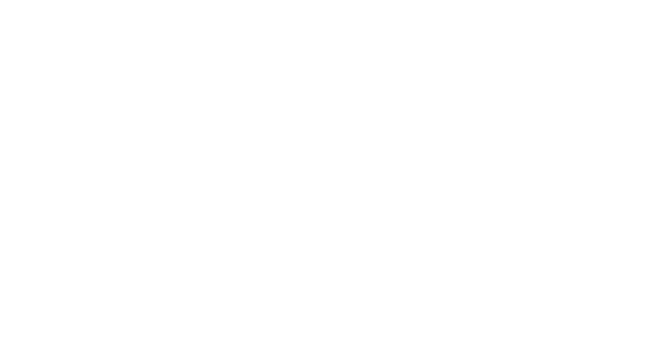

In [46]:
# Visualize
wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                min_font_size = 5).generate(all_abstract.str.cat())

# plot the WordCloud image
#plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show();

<Figure size 1000x500 with 0 Axes>

(-0.5, 799.5, 399.5, -0.5)

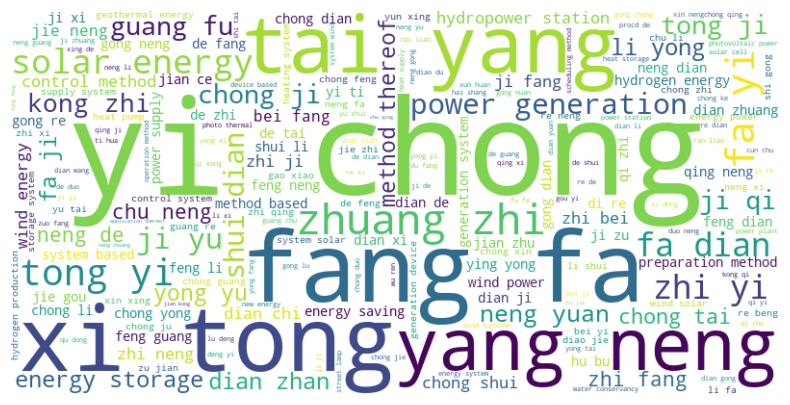

In [47]:
# WORLDCLOUD for title 
# Combine all abstracts into one large text
all_title = ' '.join(results_json['title_localized_text'].dropna())

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_title)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

In [48]:
# Assuming 'results_json' is your DataFrame and it's already loaded

# Combine texts from abstracts and titles into separate strings
abstract_text = ' '.join(results_json['abstract_localized_text'].tolist())
title_text = ' '.join(results_json['title_localized_text'].tolist())

# Create word cloud objects
abstract_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(abstract_text)
title_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title_text)

# Setup matplotlib figures
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display the word clouds
axes[0].imshow(abstract_wordcloud, interpolation='bilinear')
axes[0].set_title('Text Word Cloud')
axes[0].axis('off')  # Hide the axes for abstract word cloud

axes[1].imshow(title_wordcloud, interpolation='bilinear')
axes[1].set_title('Titles Word Cloud')
axes[1].axis('off')  # Hide the axes for title word cloud

plt.tight_layout()
plt.show();


MemoryError: 

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='abstract_token_count', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Abstract Token Count')

Text(0.5, 0, 'Abstract Token Count')

Text(0, 0.5, 'Frequency')

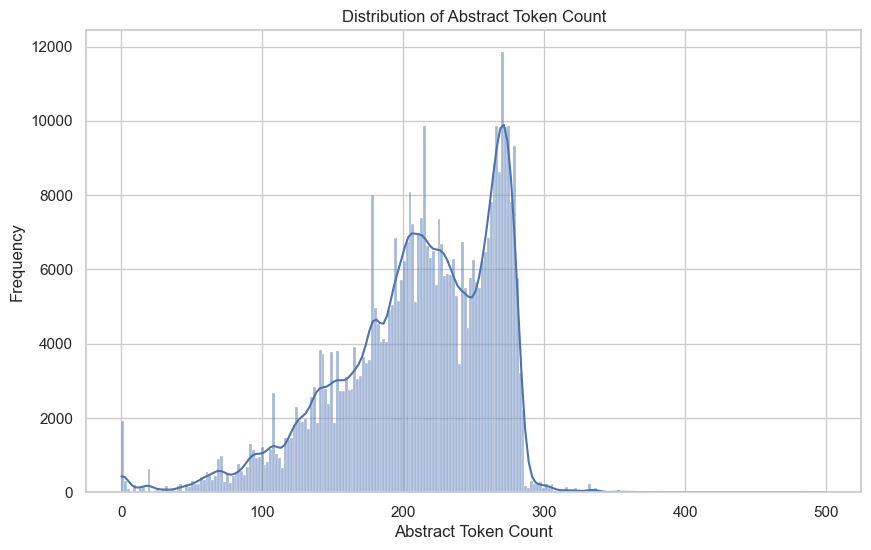

In [49]:
# Histogram for abstract token count
plt.figure(figsize=(10, 6))
sns.histplot(results_json['abstract_token_count'], kde=True)
plt.title('Distribution of Abstract Token Count')
plt.xlabel('Abstract Token Count')
plt.ylabel('Frequency')
plt.show();

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='abstract_token_count', ylabel='title_token_count'>

Text(0.5, 1.0, 'Abstract vs Title Token Count')

Text(0.5, 0, 'Abstract Token Count')

Text(0, 0.5, 'Title Token Count')

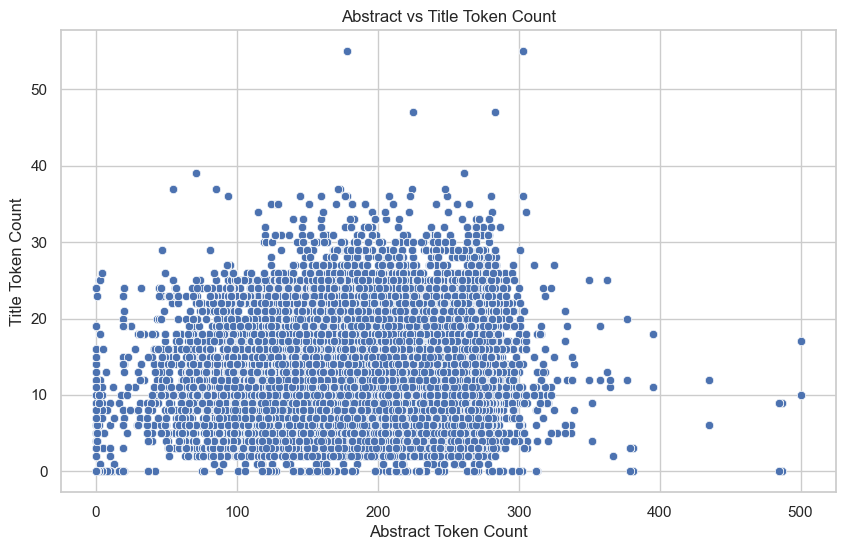

In [50]:
# Scatter plot for abstract vs title token count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_json, x='abstract_token_count', y='title_token_count')
plt.title('Abstract vs Title Token Count')
plt.xlabel('Abstract Token Count')
plt.ylabel('Title Token Count')
plt.show();

In [55]:
results_json.columns[:-4]

Index(['publication_number', 'country_code', 'publication_date', 'inventor',
       'title_localized_text', 'title_localized_language',
       'abstract_localized_text', 'abstract_localized_language', 'cpc_code'],
      dtype='object')

In [56]:
# Group by 'publication_number' and aggregate other columns to count entries
group_columns = [col for col in results_json.columns[:-4] if col != 'publication_number']
grouped = results_json.groupby('publication_number').agg({col: lambda x: x.dropna().nunique() for col in group_columns}).reset_index()

# Get the value counts for 'publication_number' and merge it with the grouped DataFrame
grouped = grouped.merge(results_json['publication_number'].value_counts().rename('publication_count').reset_index(), on='publication_number', how='left')

# Display the resulting DataFrame
grouped

,publication_number,country_code,publication_date,inventor,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language,cpc_code,publication_count
0,AU-2016208290-B2,1,1,1,1,1,1,1,2,2
1,AU-2016321918-B2,1,1,2,1,1,1,1,8,16
2,AU-2017246326-B2,1,1,1,1,1,1,1,8,8
3,AU-2017267740-B2,1,1,2,1,1,1,1,11,22
4,AU-2017276466-B2,1,1,1,1,1,1,1,13,13
...,...,...,...,...,...,...,...,...,...,...
13407,WO-2022150919-A1,1,1,3,2,2,2,2,0,12
13408,WO-2022152757-A1,1,1,1,3,3,3,3,12,108
13409,WO-2022152759-A2,1,1,1,3,3,3,3,15,135
13410,WO-2022154333-A1,1,1,1,3,3,3,3,0,9


<Figure size 1000x600 with 0 Axes>

<Axes: ylabel='inventor'>

Text(0.5, 1.0, 'Boxplot of Number of Inventors (Excluding Zero Inventors)')

Text(0, 0.5, 'Number of Inventors')

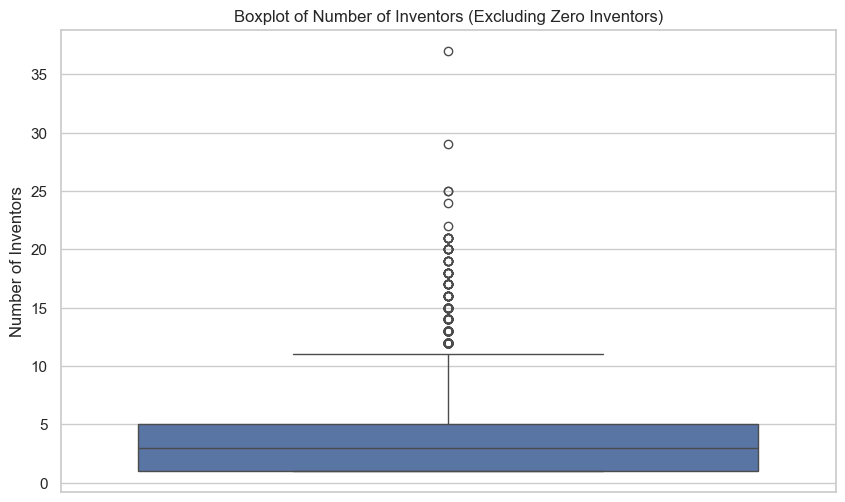

In [57]:
# Boxplot for number of inventors
# Exclude rows with zero inventors.
filtered_data = grouped[grouped['inventor'] > 0]

# Now, we can create a boxplot for the number of inventors.
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, y='inventor')
plt.title('Boxplot of Number of Inventors (Excluding Zero Inventors)')
plt.ylabel('Number of Inventors')
plt.show();

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='inventor', ylabel='Count'>

Text(0.5, 1.0, 'Histogram with KDE of Number of Inventors (Excluding Zero Inventors)')

Text(0.5, 0, 'Number of Inventors')

Text(0, 0.5, 'Count')

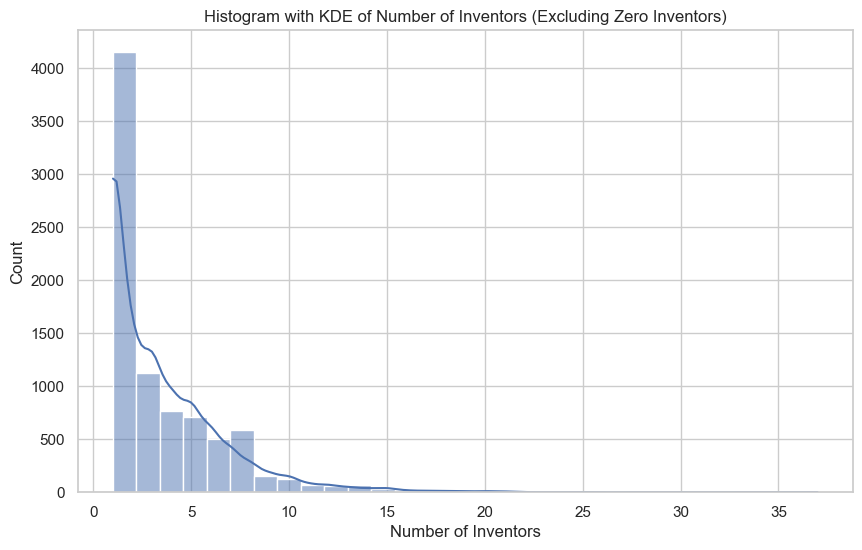

In [58]:
# Kernel Density Estimate (KDE) plot
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['inventor'], bins=30, kde=True)
plt.title('Histogram with KDE of Number of Inventors (Excluding Zero Inventors)')
plt.xlabel('Number of Inventors')
plt.ylabel('Count')
plt.show();

In [ ]:
# Bar chart for publications per country
plt.figure(figsize=(10, 6))
sns.countplot(data=results_json, x='country_code', order=results_json['country_code'].value_counts().index)
plt.title('Number of Publications Per Country')
plt.xlabel('Country Code')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.show();

<Figure size 1000x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Language Distribution in Abstracts')

Text(0.5, 0, 'Number of Abstracts')

Text(0, 0.5, 'Language')

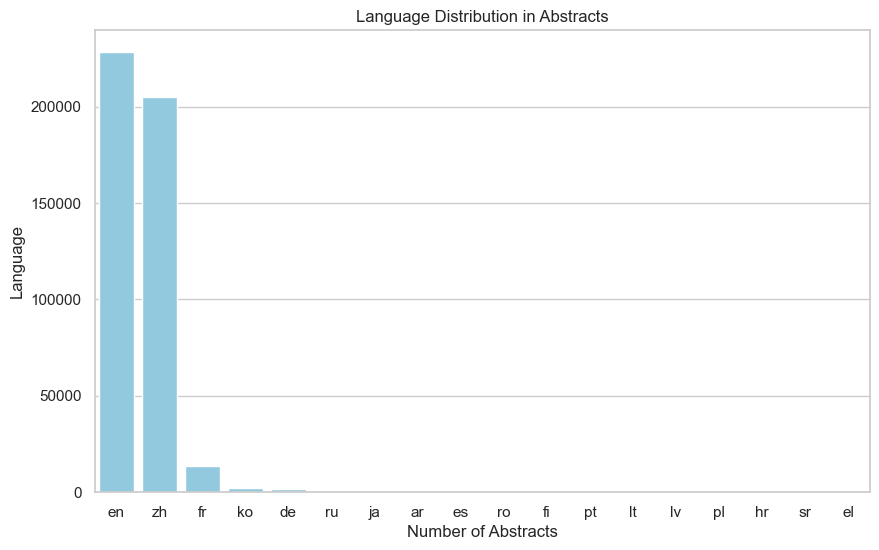

<Figure size 1000x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Language Distribution in Titles')

Text(0.5, 0, 'Number of Titles')

Text(0, 0.5, 'Language')

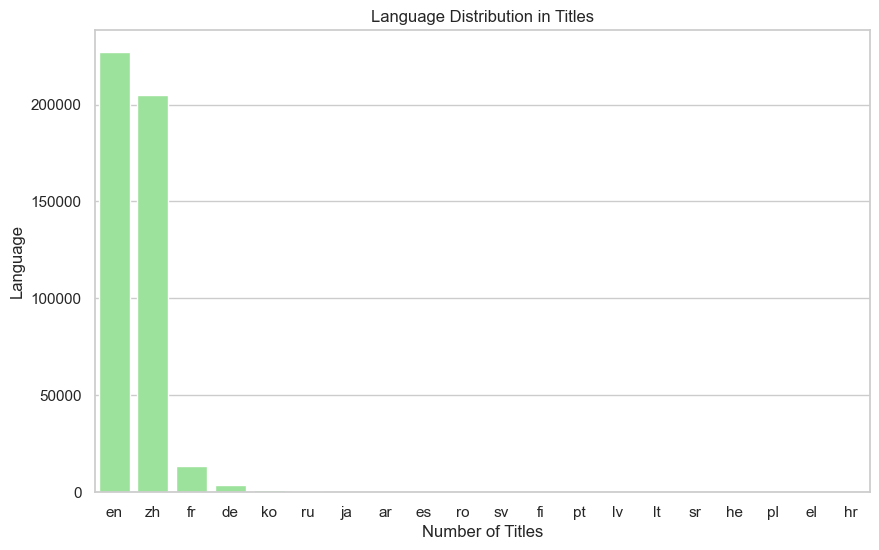

In [60]:
# Plot for language distribution in abstracts
plt.figure(figsize=(10, 6))
sns.barplot(x=[item[0] for item in abstract_lang_distribution.values], y=[item[1] for item in abstract_lang_distribution.values], color='skyblue')
plt.title('Language Distribution in Abstracts')
plt.xlabel('Number of Abstracts')
plt.ylabel('Language')
plt.show();

# Plot for language distribution in titles
plt.figure(figsize=(10, 6))
sns.barplot(x=[item[0] for item in title_lang_distribution.values], y=[item[1] for item in title_lang_distribution.values], color='lightgreen')
plt.title('Language Distribution in Titles')
plt.xlabel('Number of Titles')
plt.ylabel('Language')
plt.show();


#### UNIGRAMS 

#### Unigram with stopwords

In [61]:
# Function to get top n unigrams
def get_top_n_words(corpus, n=None, stopwords=None):
    vec = CountVectorizer(stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [62]:
top_n_unigrams = get_top_n_words(results_json['abstract_localized_text'], n=20)
df_unigrams = pd.DataFrame(top_n_unigrams, columns=['word', 'count'])

<Figure size 1000x500 with 0 Axes>

<Axes: xlabel='count', ylabel='word'>

Text(0.5, 1.0, 'Top 20 unigrams in abstracts without stopwords')

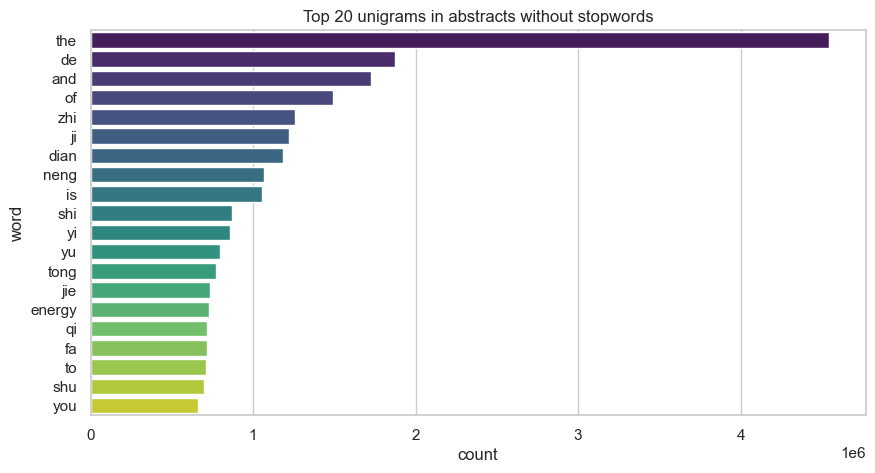

In [63]:
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='word', data=df_unigrams, palette='viridis', hue='word')
plt.title('Top 20 unigrams in abstracts without stopwords')
plt.show();

#### Unigram without stopwords

In [64]:
top_n_unigrams_stop = get_top_n_words(results_json['abstract_localized_text'], n=20, stopwords='english')
df_unigrams_stop = pd.DataFrame(top_n_unigrams_stop, columns=['word', 'count'])

<Figure size 1000x500 with 0 Axes>

<Axes: xlabel='count', ylabel='word'>

Text(0.5, 1.0, 'Top 20 unigrams in abstracts with stopwords removed')

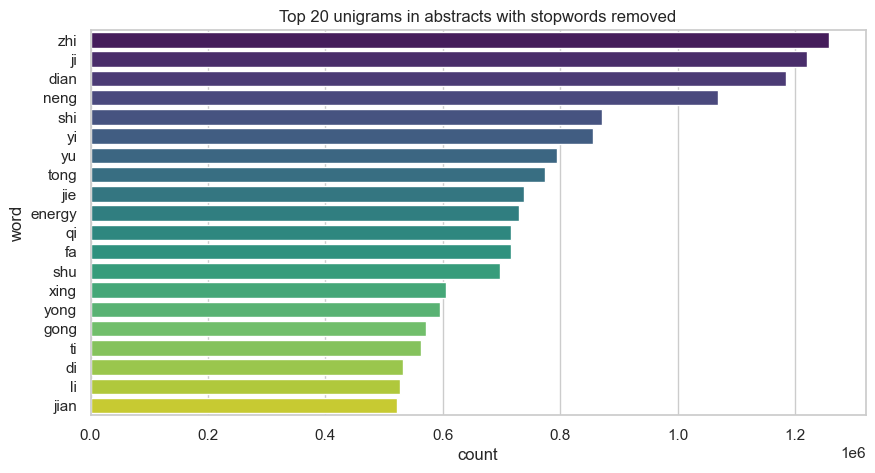

In [65]:
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='word', data=df_unigrams_stop, palette='viridis', hue='word')
plt.title('Top 20 unigrams in abstracts with stopwords removed')
plt.show()

#### Bigrams 

<Figure size 1000x500 with 0 Axes>

<Axes: xlabel='count', ylabel='bigram'>

Text(0.5, 1.0, 'Top 20 bigrams in abstracts')

Text(0.5, 0, 'Count')

Text(0, 0.5, 'Bigram')

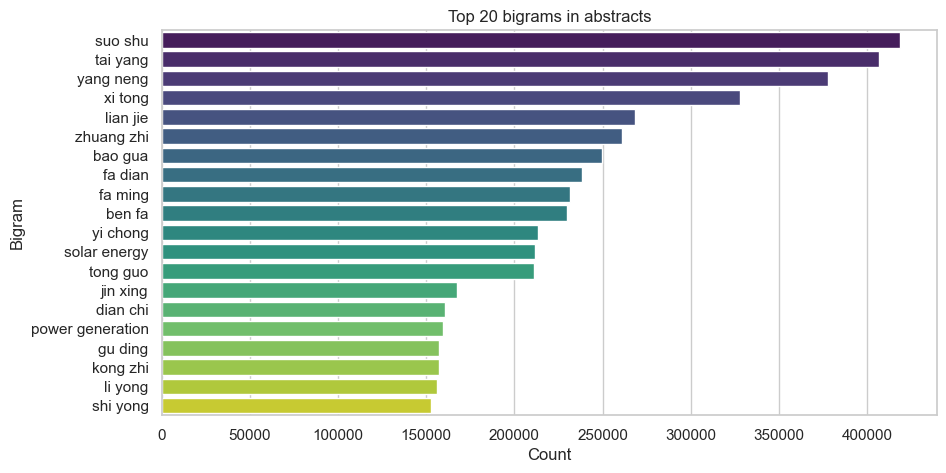

In [66]:
def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Assuming 'results_json' is your DataFrame and 'abstract_text' is the column with abstracts
# Get the top n bigrams from the abstracts
top_n_bigrams = get_top_n_bigrams(results_json['abstract_localized_text'], n=20)
df_bigrams = pd.DataFrame(top_n_bigrams, columns=['bigram', 'count'])

# Plot the top n bigrams
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='bigram', data=df_bigrams, palette='viridis', hue='bigram')
plt.title('Top 20 bigrams in abstracts')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show();

#### Handle duplicates 


We decided to handle duplicates after convertion of columns (for easier process and to avoid overwriting the code).

In [67]:
# Convert list columns to strings to enable hashing
results_json['abstract_tokens_str'] = results_json['abstract_tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
results_json['title_tokens_str'] = results_json['title_tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Temporarily drop columns that may contain complex data types like lists or dicts
temp_df = results_json.drop(columns=['abstract_tokens', 'title_tokens', 'inventor'])

# Now check for duplicates in this temporary DataFrame
duplicates = temp_df.duplicated(subset=None, keep='first').sum()
print(f"Remaining duplicates: {duplicates}")

# If you want to remove duplicates, do so and then add back the dropped columns
#if duplicates > 0:
    #results_json = results_json.loc[~temp_df.duplicated(subset=None, keep='first')].reset_index(drop=True)

# You can drop duplicates if needed using the following line:
# results_json = results_json.drop_duplicates(subset=None, keep='first').reset_index(drop=True)


Remaining duplicates: 298068


In [68]:
# Identify duplicates
is_duplicate = temp_df.duplicated(subset=None, keep='first')
is_duplicate.head(10)

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
dtype: bool

In [69]:
# Remove duplicates
results_json = results_json[~is_duplicate].reset_index(drop=True)

# Print the head of the DataFrame to inspect the first few rows
results_json.head()
#Mabye add this step before visualizations.

,publication_number,country_code,publication_date,inventor,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language,cpc_code,abstract_tokens,title_tokens,abstract_token_count,title_token_count,abstract_tokens_str,title_tokens_str
0,US-2022239235-A1,US,2022-07-28,NaN,adaptable dc ac inverter drive system and oper...,en,disclosed is an adaptable dc ac inverter syste...,en,H02M7/5395,"[disclosed, is, an, adaptable, dc, ac, inverte...","[adaptable, dc, ac, inverter, drive, system, a...",67,8,disclosed is an adaptable dc ac inverter syste...,adaptable dc ac inverter drive system and oper...
1,US-2022239235-A1,US,2022-07-28,NaN,adaptable dc ac inverter drive system and oper...,en,disclosed is an adaptable dc ac inverter syste...,en,H02J3/32,"[disclosed, is, an, adaptable, dc, ac, inverte...","[adaptable, dc, ac, inverter, drive, system, a...",67,8,disclosed is an adaptable dc ac inverter syste...,adaptable dc ac inverter drive system and oper...
2,US-2022239235-A1,US,2022-07-28,NaN,adaptable dc ac inverter drive system and oper...,en,disclosed is an adaptable dc ac inverter syste...,en,H02M1/32,"[disclosed, is, an, adaptable, dc, ac, inverte...","[adaptable, dc, ac, inverter, drive, system, a...",67,8,disclosed is an adaptable dc ac inverter syste...,adaptable dc ac inverter drive system and oper...
3,US-2022239235-A1,US,2022-07-28,NaN,adaptable dc ac inverter drive system and oper...,en,disclosed is an adaptable dc ac inverter syste...,en,H02J1/10,"[disclosed, is, an, adaptable, dc, ac, inverte...","[adaptable, dc, ac, inverter, drive, system, a...",67,8,disclosed is an adaptable dc ac inverter syste...,adaptable dc ac inverter drive system and oper...
4,US-2022239235-A1,US,2022-07-28,NaN,adaptable dc ac inverter drive system and oper...,en,disclosed is an adaptable dc ac inverter syste...,en,H02J3/381,"[disclosed, is, an, adaptable, dc, ac, inverte...","[adaptable, dc, ac, inverter, drive, system, a...",67,8,disclosed is an adaptable dc ac inverter syste...,adaptable dc ac inverter drive system and oper...


## CSV PROCESSING

#### CT_Evaluation cleaning

In [70]:
# Look into unique characters to indentify which ones to remove
# Create sets to hold unique characters
unique_chars_question = set()
unique_chars_chunk = set()

# Update sets with characters from each row
for question, chunk in zip(ct_evaluation['question'], ct_evaluation['relevant_chunk']):
    unique_chars_question.update(question)
    unique_chars_chunk.update(chunk)

# Print the unique characters
print("Unique characters in 'question' column:")
print(sorted(unique_chars_question))
print("\nUnique characters in 'relevant_chunk' column:")
print(sorted(unique_chars_chunk))

Unique characters in 'question' column:
[' ', '"', "'", ',', '-', '0', '1', '2', '3', '5', '?', 'A', 'C', 'D', 'E', 'G', 'H', 'I', 'L', 'M', 'P', 'S', 'U', 'W', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'é', '’']

Unique characters in 'relevant_chunk' column:
[' ', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '8', '9', ':', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é', '–', '’', '“', '”']


In [71]:
# Initialize a lemmatizer
lemmatizer = WordNetLemmatizer()

def standardize_text(text):
    # Normalize and convert to lowercase
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8').lower()
    
    # Replace special apostrophes and quotation marks
    text = text.replace('’', "'").replace('“', '"').replace('”', '"')
    
    # Standardize dashes
    text = text.replace('–', '-')  # Replace en-dash with hyphen
    
    #remove links
    text = re.sub(r'<[^>]*>', ' ', text)
    
    # Remove punctuation and numbers
    text = re.sub(r'[\W_]+', ' ', text)  # \W_ matches any non-alphanumeric character underscore included
    
    return text
    

# Apply the cleaning function to both 'question' and 'relevant_chunk' columns
ct_evaluation['question'] = ct_evaluation['question'].apply(standardize_text)
ct_evaluation['relevant_chunk'] = ct_evaluation['relevant_chunk'].apply(standardize_text)

# Display the cleaned text to confirm changes
print("Standardized 'question' column:")
print(ct_evaluation['question'].head())
print("\nStandardized 'relevant_chunk' column:")
print(ct_evaluation['relevant_chunk'].head())
##Should we remove numbers as well?

Standardized 'question' column:
0    what is the innovation behind leclanche s new ...
1          what is the eus green deal industrial plan 
2          what is the eus green deal industrial plan 
3    what are the four focus areas of the eu s gree...
4    when did the cooperation between gm and honda ...
Name: question, dtype: object

Standardized 'relevant_chunk' column:
0    leclanche said it has developed an environment...
1    the green deal industrial plan is a bid by the...
2    the european counterpart to the us inflation r...
3    the new plan is fundamentally focused on four ...
4    what caught our eye was a new hookup between g...
Name: relevant_chunk, dtype: object


In [72]:
# Function to extract unique characters from text
def extract_unique_characters(text_series):
    unique_characters = set()
    for text in text_series:
        unique_characters.update(text)
    return sorted(unique_characters)

# Apply the function to cleaned 'question' and 'relevant_chunk' columns
unique_chars_in_question_cleaned = extract_unique_characters(ct_evaluation['question'])
unique_chars_in_chunk_cleaned = extract_unique_characters(ct_evaluation['relevant_chunk'])

# Display the unique characters
print("Unique characters in cleaned 'question' column:")
print(unique_chars_in_question_cleaned)
print("\nUnique characters in cleaned 'relevant_chunk' column:")
print(unique_chars_in_chunk_cleaned)

Unique characters in cleaned 'question' column:
[' ', '0', '1', '2', '3', '5', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z']

Unique characters in cleaned 'relevant_chunk' column:
[' ', '0', '1', '2', '3', '4', '5', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [73]:
# Function to count tokens in text
def count_tokens(text):
    return len(text.split())

# Count tokens and create new columns
ct_evaluation['question_token_count'] = ct_evaluation['question'].apply(count_tokens)
ct_evaluation['relevant_chunk_token_count'] = ct_evaluation['relevant_chunk'].apply(count_tokens)

# Display the DataFrame to confirm changes
print("\nDataFrame with token counts:")
print(ct_evaluation[['question', 'question_token_count', 'relevant_chunk', 'relevant_chunk_token_count']].head())


DataFrame with token counts:
                                            question  question_token_count  \
0  what is the innovation behind leclanche s new ...                    14   
1        what is the eus green deal industrial plan                      8   
2        what is the eus green deal industrial plan                      8   
3  what are the four focus areas of the eu s gree...                    14   
4  when did the cooperation between gm and honda ...                    13   

                                      relevant_chunk  \
0  leclanche said it has developed an environment...   
1  the green deal industrial plan is a bid by the...   
2  the european counterpart to the us inflation r...   
3  the new plan is fundamentally focused on four ...   
4  what caught our eye was a new hookup between g...   

   relevant_chunk_token_count  
0                          42  
1                          47  
2                          37  
3                          42  
4   

#### URL cleaning

In [74]:
# Summary of the article_url column
url_summary = ct_evaluation['article_url'].agg(['dtype', 'nunique', 'count', pd.Series.nunique, pd.Series.unique])

# Check for missing values
url_summary['missing_values'] = ct_evaluation['article_url'].isnull().sum()

# Display the summary
url_summary

dtype                                                        object
nunique                                                          21
count                                                            23
nunique                                                          21
unique            [https://www.sgvoice.net/strategy/technology/2...
missing_values                                                    0
Name: article_url, dtype: object

In [75]:
def clean_url(url):
    # Parse the URL
    parsed_url = urlparse(url.lower())
    # Reconstruct without query and fragment
    cleaned_url = urlunparse((parsed_url.scheme, parsed_url.netloc, parsed_url.path, '', '', ''))
    return cleaned_url

def extract_domain(url):
    # Parse the URL and extract the domain
    domain = urlparse(url.lower()).netloc
    # Remove 'www.' if it exists
    domain = domain.replace('www.', '')
    # Extract only the main part of the domain before the first dot
    main_part = domain.split('.')[0]
    return main_part

# Apply cleaning to the article_url column
ct_evaluation['cleaned_article_url'] = ct_evaluation['article_url'].apply(clean_url)
ct_evaluation['domain'] = ct_evaluation['article_url'].apply(extract_domain)

# Display the cleaned URLs and domains
ct_evaluation[['article_url', 'cleaned_article_url', 'domain']]

,article_url,cleaned_article_url,domain
0,https://www.sgvoice.net/strategy/technology/23...,https://www.sgvoice.net/strategy/technology/23...,sgvoice
1,https://www.sgvoice.net/policy/25396/eu-seeks-...,https://www.sgvoice.net/policy/25396/eu-seeks-...,sgvoice
2,https://www.pv-magazine.com/2023/02/02/europea...,https://www.pv-magazine.com/2023/02/02/europea...,pv-magazine
3,https://www.sgvoice.net/policy/25396/eu-seeks-...,https://www.sgvoice.net/policy/25396/eu-seeks-...,sgvoice
4,https://cleantechnica.com/2023/05/08/general-m...,https://cleantechnica.com/2023/05/08/general-m...,cleantechnica
5,https://solarindustrymag.com/scout-and-colgate...,https://solarindustrymag.com/scout-and-colgate...,solarindustrymag
6,https://cleantechnica.com/2023/01/02/the-wait-...,https://cleantechnica.com/2023/01/02/the-wait-...,cleantechnica
7,https://cleantechnica.com/2023/05/15/what-does...,https://cleantechnica.com/2023/05/15/what-does...,cleantechnica
8,https://cleantechnica.com/2023/05/15/mississip...,https://cleantechnica.com/2023/05/15/mississip...,cleantechnica
9,https://cleantechnica.com/2023/05/18/solar-pan...,https://cleantechnica.com/2023/05/18/solar-pan...,cleantechnica


In [76]:
# inspect again
ct_evaluation.head(24)

,example_id,question_id,question,relevant_chunk,article_url,question_token_count,relevant_chunk_token_count,cleaned_article_url,domain
0,1,1,what is the innovation behind leclanche s new ...,leclanche said it has developed an environment...,https://www.sgvoice.net/strategy/technology/23...,14,42,https://www.sgvoice.net/strategy/technology/23...,sgvoice
1,2,2,what is the eus green deal industrial plan,the green deal industrial plan is a bid by the...,https://www.sgvoice.net/policy/25396/eu-seeks-...,8,47,https://www.sgvoice.net/policy/25396/eu-seeks-...,sgvoice
2,3,2,what is the eus green deal industrial plan,the european counterpart to the us inflation r...,https://www.pv-magazine.com/2023/02/02/europea...,8,37,https://www.pv-magazine.com/2023/02/02/europea...,pv-magazine
3,4,3,what are the four focus areas of the eu s gree...,the new plan is fundamentally focused on four ...,https://www.sgvoice.net/policy/25396/eu-seeks-...,14,42,https://www.sgvoice.net/policy/25396/eu-seeks-...,sgvoice
4,5,4,when did the cooperation between gm and honda ...,what caught our eye was a new hookup between g...,https://cleantechnica.com/2023/05/08/general-m...,13,61,https://cleantechnica.com/2023/05/08/general-m...,cleantechnica
5,6,5,did colgate palmolive enter into ppa agreement...,scout clean energy a colorado based renewable ...,https://solarindustrymag.com/scout-and-colgate...,10,34,https://solarindustrymag.com/scout-and-colgate...,solarindustrymag
6,7,6,what is the status of zeroavia s hydrogen fuel...,in december the us startup zeroavia announced ...,https://cleantechnica.com/2023/01/02/the-wait-...,12,30,https://cleantechnica.com/2023/01/02/the-wait-...,cleantechnica
7,8,7,what is the danger season,as spring turns to summer and the days warm up...,https://cleantechnica.com/2023/05/15/what-does...,5,88,https://cleantechnica.com/2023/05/15/what-does...,cleantechnica
8,9,8,is mississipi an anti esg state,mississippi is among two dozen or so states in...,https://cleantechnica.com/2023/05/15/mississip...,6,29,https://cleantechnica.com/2023/05/15/mississip...,cleantechnica
9,10,9,can you hang solar panels on garden fences,scaling down from the farm to the garden level...,https://cleantechnica.com/2023/05/18/solar-pan...,8,53,https://cleantechnica.com/2023/05/18/solar-pan...,cleantechnica


#### Remove stopwords

In [77]:
# Function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# Remove stopwords from 'question' and 'relevant_chunk'
ct_evaluation['question_clean'] = ct_evaluation['question'].apply(remove_stopwords)
ct_evaluation['relevant_chunk_clean'] = ct_evaluation['relevant_chunk'].apply(remove_stopwords)


#### Co-occurrances analysation

In [78]:
# Function to calculate co-occurrences
def calculate_cooccurrences(data, column):
    # Define a count vectorizer
    count_vectorizer = CountVectorizer(
        max_df=0.9,
        min_df=0.01,
        stop_words='english',
        binary=True
    )

    # Transform the text into binary flags
    counts = count_vectorizer.fit_transform(data[column])

    # Get the names of each column
    ngrams = count_vectorizer.get_feature_names_out()

    # Compute the product to get a co-occurrence matrix
    cooccurs = (counts.T * counts)

    # Fill the diagonal with zeros
    cooccurs.setdiag(0)

    # Convert to a dense format and make a DataFrame
    cooccurs_df = pd.DataFrame(cooccurs.todense(), index=ngrams, columns=ngrams)
    
    return cooccurs_df

# Calculate co-occurrences for the 'abstract_text' column
cooccurs_question = calculate_cooccurrences(ct_evaluation, 'question')

# Calculate co-occurrences for the 'title_text' column
cooccurs_relevant_chunk = calculate_cooccurrences(ct_evaluation, 'relevant_chunk')

# Display the co-occurrence DataFrames
print("Co-occurrences in question:")
cooccurs_question.head()


Co-occurrences in question:


,2021,500m,absorption,agreements,agrivoltaics,aircraft,amorphous,anti,apples,areas,...,total,turbines,used,user,using,vehicles,warming,wavelengths,winters,zeroavia
2021,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
500m,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
absorption,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
agreements,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
agrivoltaics,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
print("\nCo-occurrences in relevant_chunk:")
cooccurs_relevant_chunk.head()


Co-occurrences in relevant_chunk:


,14,19,200,2012,2013,2021,2030,209,228,500,...,white,wildfire,wildfires,winter,wintertime,worked,year,years,zero,zeroavia
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
200,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2012,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2013,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [80]:
# Define a count vectorizer that will create binary flags indicating the presence of each word
count_vectorizer = CountVectorizer(
    min_df=.08,
    max_df=100,
    stop_words='english',
    binary=True
)
# Transform the text into binary flags
counts_question = count_vectorizer.fit_transform(ct_evaluation, 'question')
counts_relevant_chunk = count_vectorizer.fit_transform(ct_evaluation, 'relevant_chunk')

# Get the names of each column
ngrams = count_vectorizer.get_feature_names_out()
# Compute the product to get a co-occurrence matrix
cooccurs = (counts_question.T * counts_question)  # Calculate co-occurrence for questions
cooccurs += (counts_relevant_chunk.T * counts_relevant_chunk)  # Add co-occurrence for relevant chunks
# Fill the diagonal with zeroes
cooccurs.setdiag(0)
# Put it into a Pandas DataFrame to make it pretty
cooccurs = pd.DataFrame(cooccurs.todense(), index=ngrams, columns=ngrams)
cooccurs.head()

,article_url,cleaned_article_url,domain,example_id,question,question_clean,question_id,question_token_count,relevant_chunk,relevant_chunk_clean,relevant_chunk_token_count
article_url,0,0,0,0,0,0,0,0,0,0,0
cleaned_article_url,0,0,0,0,0,0,0,0,0,0,0
domain,0,0,0,0,0,0,0,0,0,0,0
example_id,0,0,0,0,0,0,0,0,0,0,0
question,0,0,0,0,0,0,0,0,0,0,0


In [81]:
def calculate_cooccurrences(texts, max_df, min_df, stop_words, binary):
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words=stop_words, binary=binary)
    X = vectorizer.fit_transform(texts)
    Xc = (X.T * X)  # This is the matrix manipulation step
    Xc.setdiag(0)  # We set the diagonal to be zeroes as we don't want to count self co-occurrences
    names = vectorizer.get_feature_names_out()
    return pd.DataFrame(data = Xc.toarray(), columns = names, index = names)

# Assuming 'ct_evaluation' is your dataframe and it has columns 'question' and 'relevant_chunk'
# We also assume that the texts have been preprocessed and tokenized if necessary.

# Calculate co-occurrences, ensure to set min_df to a value that makes sense for your dataset size
question_cooccurrences = calculate_cooccurrences(ct_evaluation['question'], 
                                                 max_df=0.9, min_df=5, 
                                                 stop_words='english', binary=True)
chunk_cooccurrences = calculate_cooccurrences(ct_evaluation['relevant_chunk'], 
                                              max_df=0.9, min_df=5, 
                                              stop_words='english', binary=True)

# Now you can display the head of these dataframes
print(question_cooccurrences.head())
print(chunk_cooccurrences.head())



       solar
solar      0
       solar
solar      0


#### Worldcloud

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Word Cloud for Questions')

(-0.5, 799.5, 399.5, -0.5)

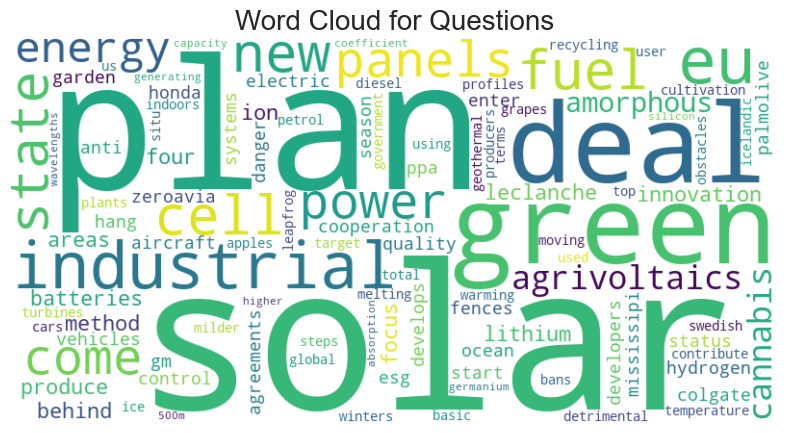

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Word Cloud for Relevant Chunks')

(-0.5, 799.5, 399.5, -0.5)

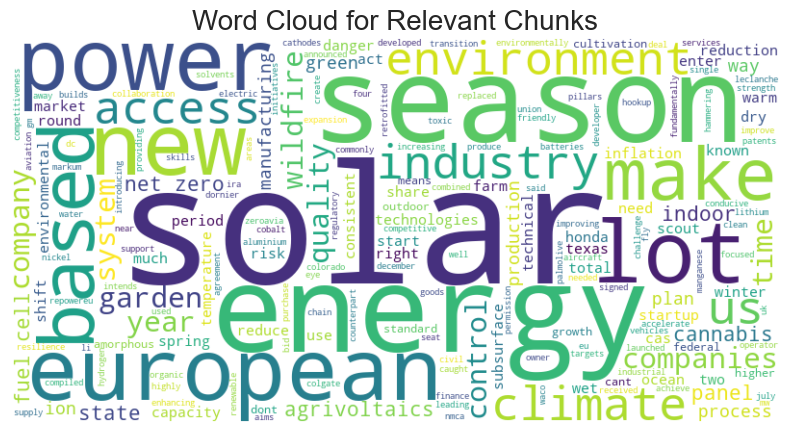

In [82]:
# Generate word cloud for questions
wordcloud_question = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(ct_evaluation['question_clean']))
wordcloud_chunk = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(ct_evaluation['relevant_chunk_clean']))

# Display the WordCloud image for questions
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_question, interpolation='bilinear')
plt.title('Word Cloud for Questions', fontsize=20)
plt.axis("off")
plt.show();

# Display the WordCloud image for relevant chunks
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_chunk, interpolation='bilinear')
plt.title('Word Cloud for Relevant Chunks', fontsize=20)
plt.axis("off")
plt.show();

#### CT_Media Cleaning

In [83]:
def unique_characters(column):
    return set(''.join(column))

# Load your data (assuming DataFrame is named ct_media)
# ct_media = pd.read_csv('path_to_your_file.csv')

# Inspect unique characters in the title
title_chars = unique_characters(ct_media['title'])
print("Unique characters in 'title':", title_chars)

# Inspect unique characters in the content
content_chars = unique_characters(ct_media['content'])
print("Unique characters in 'content':", content_chars)


Unique characters in 'title': {' ', 'z', '‘', 'N', 'A', '$', 'K', 'Y', '1', '€', 't', '’', 'ö', 'r', '⅓', "'", ':', '#', '5', 'j', 'q', 'R', '0', '₂', '—', 's', '™', 'D', '8', ']', 'u', '>', '°', '\u200b', 'U', 'í', '“', 'b', '4', 'F', 'à', '½', 'v', 'J', 'ó', 'å', 'á', 'I', 'c', 'O', '(', 'L', '-', 'm', 'a', '?', 'E', '*', '7', '+', ';', '×', '~', 'd', 'p', 'T', 'ø', '=', 'w', '3', 'n', '`', 'ú', 'e', '.', 'Ö', 'P', '/', 'ü', ')', 'ç', '9', 'ē', '@', 'B', '…', 'W', 'g', '2', 'l', 'k', 'ë', '%', 'C', '£', 'É', 'Z', 'G', 'S', '®', '⅙', 'M', 'y', 'X', '&', 'o', '6', 'Q', 'h', 'Ø', 'H', 'é', 'i', 'ä', '–', ',', 'â', '”', 'x', '!', '[', 'V', 'f'}
Unique characters in 'content': {'″', ' ', '‘', 'ć', 'ь', 'В', 'ப', 'Э', 'Y', 'γ', 'ا', '대', 'ா', 'い', 'ă', '’', 'ě', 'î', '·', 'வ', 'ε', 'э', '형', 'р', 'У', '5', 'ழ', 'È', 'ɑ', '0', 'ō', 'è', '🚗', '🤷', 'ș', '™', 'D', 'Т', 'ம', 'Å', '毛', '±', 'b', 'й', 'З', 'Ц', '{', '‐', 'J', 'å', 'O', '(', '⋅', '³', 'Ü', '🙂', '迈', ';', 'd', 'Ш', 'ª', '=', 'Ł', '

### Cleaning Title

In [84]:
def clean_title(text):
    # Normalize unicode characters and convert to lower
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8').lower()
    # Remove special characters
    text = re.sub(r'[^\w\s-]', '', text)
    return text

# Apply the cleaning function to the title column
ct_media['title'] = ct_media['title'].apply(clean_title)

# Display the cleaned titles
print(ct_media['title'].head())

#examine unique characters again
title_chars = unique_characters(ct_media['title'])
print("Unique characters in 'title':", title_chars)

0    qatar to slash emissions as lng expansion adva...
1                 india launches its first 700 mw phwr
2                new chapter for us-china energy trade
3    japan slow restarts cast doubt on 2030 energy ...
4       nyc pension funds to divest fossil fuel shares
Name: title, dtype: object
Unique characters in 'title': {' ', 'k', 'z', '7', 'd', 'p', '8', 'y', 'u', 'w', '3', '1', 'o', '6', 't', 'h', 'n', 'b', '4', 'e', 'r', 'i', 'v', 'x', '9', '5', 'j', 'c', '-', 'q', 'm', 'g', 'a', '0', '2', 'f', 's', 'l'}


### Cleaning content

In [85]:
def clean_content(text):
    # Normalize unicode characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8').lower()
    # Remove HTML tags (if any)
    text = re.sub(r'<[^>]+>', '', text)
    # Remove emojis
    text = re.sub(r'[^\w\s.,-]', '', text)
    return text

# Apply the cleaning function to the content column
ct_media['content'] = ct_media['content'].apply(clean_content)

# Display the cleaned content
print(ct_media['content'].head())

# Inspect unique characters in the content
content_chars = unique_characters(ct_media['content'])
print("Unique characters in 'content':", content_chars)

0    qatar petroleum  qp is targeting aggressive cu...
1     nuclear power corp. of india ltd.  npcil sync...
2    new us president joe biden took office this we...
3    the slow pace of japanese reactor restarts con...
4    two of new york citys largest pension funds sa...
Name: content, dtype: object
Unique characters in 'content': {' ', 'k', 'z', '7', 'd', 'p', '8', 'y', 'u', 'w', '3', '1', 'o', '6', 't', 'h', 'n', 'b', '4', 'e', '.', 'r', 'i', 'v', ',', 'x', '9', '5', 'j', 'c', '-', 'q', 'm', 'g', 'a', '0', '2', 'f', 's', 'l'}


In [86]:
# ct_media['title'][2270]
# ct_media['content'][2270]

#### TOKANIZATION


In [ ]:
# You might need to download the NLTK tokenizer resources
#nltk.download('punkt')

# Applying tokenization
ct_media['tokenized_content'] = ct_media['content'].apply(word_tokenize)
ct_media['tokenized_title'] = ct_media['title'].apply(word_tokenize)

# Count tokens in both content and title
ct_media['content_token_count'] = ct_media['tokenized_content'].apply(len)
ct_media['title_token_count'] = ct_media['tokenized_title'].apply(len)

# Display the first few entries with token counts
print(ct_media[['tokenized_title', 'title_token_count', 'tokenized_content', 'content_token_count']].head())


#### CONTENT

In [ ]:
# Frequency distribution of words

# Flatten the list of tokens and count the frequencies
all_tokens = [token for sublist in ct_media['tokenized_content'] for token in sublist]
freq_dist = FreqDist(all_tokens)

# Print the 10 most common words
print(freq_dist.most_common(10))

# Stopword removal
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Apply stopword removal
ct_media['filtered_content'] = ct_media['tokenized_content'].apply(remove_stopwords)

# Join tokens back to strings
ct_media['processed_content'] = ct_media['filtered_content'].apply(lambda x: ' '.join(x))

# Initialize a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the processed content
tfidf_matrix = tfidf_vectorizer.fit_transform(ct_media['processed_content'])

# You can explore tfidf_matrix here or proceed with machine learning modeling


#### TITLE

In [ ]:
# Flatten the list of tokens from titles and count the frequencies
all_title_tokens = [token for sublist in ct_media['tokenized_title'] for token in sublist]
title_freq_dist = FreqDist(all_title_tokens)

# Print the 10 most common words in titles
print(title_freq_dist.most_common(10))


In [ ]:
# Function to remove stopwords from titles
ct_media['filtered_title'] = ct_media['tokenized_title'].apply(remove_stopwords)
print(ct_media['filtered_title'].head())

In [ ]:
# Join tokens back to strings for titles
ct_media['processed_title'] = ct_media['filtered_title'].apply(lambda x: ' '.join(x))

# Initialize a TF-IDF Vectorizer for titles
title_tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the processed titles
title_tfidf_matrix = title_tfidf_vectorizer.fit_transform(ct_media['processed_title'])

In [ ]:
# Join tokens back to strings for titles
ct_media['processed_title'] = ct_media['filtered_title'].apply(lambda x: ' '.join(x))

# Initialize a TF-IDF Vectorizer for titles
title_tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the processed titles
title_tfidf_matrix = title_tfidf_vectorizer.fit_transform(ct_media['processed_title'])

# If you need to explore the shape or type of the matrix
print(title_tfidf_matrix.shape)

#### Handle missing values in author - split at the end to create two separate dataframes


In [ ]:
# Creating a DataFrame only with entries that have an author
ct_media_with_authors = ct_media.dropna(subset=['author'])
ct_media_with_authors.head()
print("Entries with authors:", ct_media_with_authors.shape[0])

# Creating a DataFrame for entries without an author
ct_media_without_authors = ct_media[ct_media['author'].isnull()]
ct_media_without_authors.head()
print("Entries without authors:", ct_media_without_authors.shape[0])


In [ ]:
# Analyze domains to see if there are patterns related to missing authors
print("\nDomain counts for entries with authors:")
ct_media_with_authors['domain'].value_counts()

print("\nDomain counts for entries without authors:")
ct_media_without_authors['domain'].value_counts()